In [1]:
# %load C60_jupyter_imports.py
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
from dask.distributed import Client
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import xesmf as xe
from scipy.stats import linregress
import os
import requests
from scipy.stats import linregress
import os
import scipy.signal as sps
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
# Lets import our functions. There are no tests here. Stored separately so as to not make a mess.
# Make sure in right dir first

os.chdir('/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/')
from C60_obs_functions import convert_trim_fratios

### Plan

Need to compare New Production, CO2 flux and SST at different locations and for different timescale resolutions. 
Assess which is the best Ensemble for Each of these.


What do we need

- Work in mols.


- CAFE New Production (Need to make detritus calculation)
- CO2 flux 

- New Production estimates
- Chlor A in mg CHL? 
- Landschutzer CO2 flux estimate (How about DELTA pCO2?)
- Reynolds OISST product


- And then detrend and deseasonalise to get different data product resolutions.

- Plot all ensembles over a Year?


In [2]:
# input params
process_interim=False
regrid_fratios=False
use_dask=True
use_heavy_dask=True

process_interim_only_wanted_vars=True
depth_integration=100

In [3]:
if use_dask==True:
    # Set up the remote dask cluster. Can either use this version or a similar version above if building a LocalCluster.
    from dask.distributed import Client,Scheduler
    from dask_jobqueue import SLURMCluster
    if use_heavy_dask==True:
        cluster = SLURMCluster(cores=8,processes=2,memory="47GB")
        client = Client(cluster)
        cluster.scale(cores=32)
        #cluster.adapt(minimum=2, maximum=16)
    else:
        cluster = SLURMCluster(cores=2,memory="16GB")
        client = Client(cluster)
        cluster.scale(cores=4)
    #cluster.adapt(minimum=2, maximum=16)
    cluster
    #client

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43405 instead
  warnings.warn(


In [4]:
# LOAD CAFE
bgc=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip')
bgc=bgc.rename({'xt_ocean':'lon','yt_ocean':'lat'})
bgc['lon']=bgc['lon']+360
eqpac=bgc.sel(lon=slice(120,290),lat=slice(-20,20))
eqpac['time']=eqpac.time.astype('datetime64[M]')
eqpac

<xarray.Dataset>
Dimensions:          (time: 720, ensemble: 96, st_ocean: 50, lat: 98, lon: 170, scalar_axis: 1)
Coordinates:
  * ensemble         (ensemble) int32 1 2 3 4 5 6 7 8 ... 90 91 92 93 94 95 96
  * scalar_axis      (scalar_axis) float64 0.0
  * st_ocean         (st_ocean) float64 5.0 15.0 25.0 ... 5.499e+03 5.831e+03
  * time             (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2019-12-01
  * lon              (lon) float64 120.5 121.5 122.5 123.5 ... 287.5 288.5 289.5
  * lat              (lat) float64 -19.36 -18.59 -17.85 ... 17.85 18.59 19.36
Data variables: (12/33)
    adic             (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 98, 170), meta=np.ndarray>
    alk              (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 98, 170), meta=np.ndarray>
    caco3            (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 98, 170), meta=np.ndarray>
    caco3_sediment   (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 98, 170), meta=np.ndarray>
    det              (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 98, 170), meta=np.ndarray>
    det_sediment     (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 98, 170), meta=np.ndarray>
    ...               ...
    surface_o2       (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 98, 170), meta=np.ndarray>
    surface_phy      (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 98, 170), meta=np.ndarray>
    surface_zoo      (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 98, 170), meta=np.ndarray>
    total_aco2_flux  (time, ensemble, scalar_axis) float32 dask.array<chunksize=(1, 96, 1), meta=np.ndarray>
    total_co2_flux   (time, ensemble, scalar_axis) float32 dask.array<chunksize=(1, 96, 1), meta=np.ndarray>
    zoo              (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 98, 170), meta=np.ndarray>
Attributes: (12/24)
    calendar:                 julian
    cm-enkf_source:          commit 0141830a243704acbf6d8c8c843b161a39ec39fa
    contact_name:            Decadal Activity 1 - Data Assimilation
    control_name:            c5
    creation_date:           Sun Dec  1 23:38:56 2019
    data_assimilation_name:  d60
    ...                      ...
    model_source:            commit 2abb29f4384e68777721fa657850587f28efd85a
    nominal_resoltuion:      Atmosphere delta lat = 2.02degrees ; Atmosphere ...
    perturbation_name:       not applicable
    references:              OKane, T.J., Sandery, P.A., Monselesan, D.P., Sa...
    run_variant_name:        data assimilation
    title:                   AccessOcean-AM2

In [ ]:
# Load Physics
phys=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip')
phys=phys.rename({'xu_ocean':'lon_x','yu_ocean':'lat_x'})
phys=phys.rename({'xt_ocean':'lon','yt_ocean':'lat'})

phys['lon']=phys['lon']+360
phys['lon_x']=phys['lon_x']+360

phys_eqpac=phys.sel(lon=slice(120,290),lat=slice(-20,20))
phys_eqpac

<xarray.Dataset>
Dimensions:                 (time: 720, ensemble: 96, st_ocean: 50, lat: 98, lon: 170, sw_ocean: 50, lon_x: 360, lat_x: 300)
Coordinates:
  * ensemble                (ensemble) int32 1 2 3 4 5 6 7 ... 91 92 93 94 95 96
  * st_ocean                (st_ocean) float64 5.0 15.0 ... 5.499e+03 5.831e+03
  * sw_ocean                (sw_ocean) float64 10.0 20.0 ... 5.665e+03 6e+03
  * time                    (time) object 1960-01-16 12:00:00 ... 2019-12-16 ...
  * lon                     (lon) float64 120.5 121.5 122.5 ... 288.5 289.5
  * lon_x                   (lon_x) float64 81.0 82.0 83.0 ... 438.0 439.0 440.0
  * lat                     (lat) float64 -19.36 -18.59 -17.85 ... 18.59 19.36
  * lat_x                   (lat_x) float64 -77.75 -77.51 -77.26 ... 89.55 90.0
Data variables: (12/22)
    age_global              (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 98, 170), meta=np.ndarray>
    cfc_11                  (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 98, 170), meta=np.ndarray>
    cfc_12                  (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 98, 170), meta=np.ndarray>
    eta_t                   (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 98, 170), meta=np.ndarray>
    neutral_diffusion_salt  (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 98, 170), meta=np.ndarray>
    neutral_diffusion_temp  (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 98, 170), meta=np.ndarray>
    ...                      ...
    tx_trans_gm             (time, ensemble, st_ocean, lat, lon_x) float32 dask.array<chunksize=(1, 96, 3, 98, 360), meta=np.ndarray>
    ty_trans                (time, ensemble, st_ocean, lat_x, lon) float32 dask.array<chunksize=(1, 96, 3, 300, 170), meta=np.ndarray>
    ty_trans_gm             (time, ensemble, st_ocean, lat_x, lon) float32 dask.array<chunksize=(1, 96, 3, 300, 170), meta=np.ndarray>
    u                       (time, ensemble, st_ocean, lat_x, lon_x) float32 dask.array<chunksize=(1, 96, 3, 300, 360), meta=np.ndarray>
    v                       (time, ensemble, st_ocean, lat_x, lon_x) float32 dask.array<chunksize=(1, 96, 3, 300, 360), meta=np.ndarray>
    wt                      (time, ensemble, sw_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 98, 170), meta=np.ndarray>
Attributes: (12/24)
    calendar:                 julian
    cm-enkf_source:          commit 0141830a243704acbf6d8c8c843b161a39ec39fa
    contact_name:            Decadal Activity 1 - Data Assimilation
    control_name:            c5
    creation_date:           Thu Apr 23 08:05:39 2020
    data_assimilation_name:  d60
    ...                      ...
    model_source:            commit 2abb29f4384e68777721fa657850587f28efd85a
    nominal_resoltuion:      Atmosphere delta lat = 2.02degrees ; Atmosphere ...
    perturbation_name:       not applicable
    references:              OKane, T.J., Sandery, P.A., Monselesan, D.P., Sa...
    run_variant_name:        data assimilation
    title:                   AccessOcean-AM2

In [ ]:
# Load OBS

land_co2=xr.open_dataset('../processed_data/obs/landshutzer_global_regrid.nc')/365 #g/m2/day
land_co2=(land_co2.fgco2_smoothed.sel(lon=slice(120,290),lat=slice(-20,20))/12)*-1000 #mmol/m2/day to match cafe. (ingassing is positive, outgassing neg)
rey_sst=xr.open_dataset('../processed_data/obs/sst.mnmean.regrid.global.nc')
rey_sst=rey_sst.sst.sel(lon=slice(120,290),lat=slice(-20,20))

In [ ]:
rodenbeck_co2=xr.open_dataset('../processed_data/obs/rodenbeck_global_regrid.nc').sel(lon=slice(120,290),lat=slice(-20,20)).co2flux_ocean

In [ ]:
#sst=xr.open_dataset('../processed_data/obs/sst.mnmean.regrid.eqpac.nc')
#sst=xr.open_dataset('../processed_data/rey_eqpac_sst_rg.nc').__xarray_dataarray_variable__
npp=xr.open_dataset('../processed_data/npp_rg/avg_npp_rg_cafe.nc').avg_npp
npp_vgpm=xr.open_dataset('../processed_data/npp_rg/avg_npp_rg_vgpm.nc').avg_npp
npp_cbpm=xr.open_dataset('../processed_data/npp_rg/avg_npp_rg_cbpm.nc').avg_npp
npp_eppley=xr.open_dataset('../processed_data/npp_rg/avg_npp_rg_eppley.nc').avg_npp
chl=xr.open_dataset('../processed_data/obs/TPCA_month_regrid.nc').__xarray_dataarray_variable__
chl_modis=xr.open_dataset('../processed_data/obs/TPCA_modis_month_regrid.nc').__xarray_dataarray_variable__

tpca=xr.open_dataset('../processed_data/obs/TPCA_month_regrid.nc').__xarray_dataarray_variable__#.mean(dim='time').plot(vmin=0,vmax=0.3)
tpca_sw=xr.open_dataset('../processed_data/obs/TPCA_sw_month_regrid.nc').__xarray_dataarray_variable__
tpca_mod=xr.open_dataset('../processed_data/obs/TPCA_modis_month_regrid.nc').__xarray_dataarray_variable__

In [ ]:
if regrid_fratios==True:
    fr=xr.open_dataset('../processed_data/fratios.nc')
    regridder = xe.Regridder(fr,bgcdatvs, 'bilinear',reuse_weights=False)
    fr_regrid=regridder(fr)
    fr_regrid.to_netcdf('../processed_data/fratios_rg.nc')
fr=xr.open_dataset('../processed_data/fratios_rg.nc')

In [22]:
np_obs=(npp/12)*fr.laws2011a

In [23]:
# F-ratio / export algo calcs
# STILL NEED TO MERGE THE TPCA ALGOS.
run_chl=False
if run_chl==True:
    chl=tpca_mod
    #CALC DIFFERENT f-ratio ALGOS. Need to multiply these ratios with the new prodution rate to get export flux.
    zeu1= 34*chl**-0.39#lee 2007
    zeu2=38*chl**-0.428#Morel 1989

    pe_dunne=-0.0101*rey_sst+0.0582*np.log(npp/zeu1)+0.419
    pe_dunne2=-0.0101*rey_sst+0.0582*np.log(npp/zeu2)+0.419
    pe_dunne3=0.0081*rey_sst+0.0668*np.log(chl/zeu2)+0.426
    f_ratio=(0.62-(0.02*rey_sst))
    th_e_ratio=(0.23*np.exp(-0.08*rey_sst))
    laws2011a=((0.5857-0.0165*rey_sst)*npp)/(51.7+npp)
    laws2011b=0.04756*(0.78-((0.43*rey_sst)/30))*npp**0.307 #avgnpp

    trim=convert_trim_fratios(trim_path='../external_data/fratios/SIMPLE_TRIM_output.nc',
                             regrid_path='../processed_data/rey_eqpac_sst_rg.nc')

In [ ]:
cafe_phy=((eqpac.surface_phy*6.625*12)/100)

In [24]:
if process_interim==True:
    # BGC
    bgcdat=eqpac.sel(ensemble=ens,method='nearest').chunk(dict(time=-1))#,lat=lat,lon=lon
    bgcdatvs=bgcdat[['pco2','pprod_gross_2d','stf10','stf07','export_prod','dic','adic','pprod_gross','det','dpco2','caco3','surface_caco3','no3','fe','alk']].sel(st_ocean=slice(0,depth_integration)).mean(dim='st_ocean')

    #ex=(bgcdat[['det']].sel(st_ocean=slice(0,depth_integration)).integrate(coord='st_ocean'))/10#10m/s)#.rename({'det':'nic_export'})
    #bgcdatvs['det_export']=ex.det

    dic_int=(bgcdat[['dic']].sel(st_ocean=slice(0,depth_integration)).integrate(coord='st_ocean'))#10m/s)#.rename({'det':'nic_export'})

    bgcdatvs['dic_integrated']=dic_int.dic

    bgcdatvs[['pprod_gross_2d','stf10','pprod_gross','stf07']]=bgcdatvs[['pprod_gross_2d','stf10','pprod_gross','stf07']]*60*60*24 # From seconds to day..

    bgcdatvs['trim_export']=bgcdatvs.pprod_gross*fr.trim
    bgcdatvs['laws_export']=bgcdatvs.pprod_gross*fr.laws2011a.mean(dim='time')
    bgcdatvs['trim_export_2d']=bgcdatvs.pprod_gross_2d*fr.trim
    bgcdatvs['laws_export_2d']=bgcdatvs.pprod_gross_2d*fr.laws2011a.mean(dim='time')


    bgcdatvs.to_netcdf('../processed_data/model_proc_temp/epac_bgc.nc')
    
if process_interim==True:
    # PHYSICS
    physdat=phys_eqpac.sel(ensemble=ens,method='nearest').chunk(dict(time=-1))
    physdatvs=physdat[['temp','salt','sst']].sel(st_ocean=slice(0,depth_integration)).mean(dim='st_ocean')
    
    # Calculate solubility from t and s....
    physdatvs=physdatvs.chunk(dict(time=-1))
    physdatvs['solubility']=xr.apply_ufunc(solubility,
                                            physdatvs['temp']+273.15,
                                            physdatvs['salt'],
                                            dask='parallelized',
                                            vectorize=True,
                                            output_dtypes=['float64'])
    physdatvs.to_netcdf('../processed_data/model_proc_temp/epac_phys.nc')

In [25]:

cluster

In [12]:

if process_interim_only_wanted_vars==True:
    # Super computer intensive. See commented SLURM code at top. 2 clusters. Maybe add more or more workers. Memory limited.
    # BGC
    print('Loading')
    bgcdat=eqpac#.chunk(dict(time=-1))#,lat=lat,lon=lon
    bgcdatvs=bgcdat[['pprod_gross_2d','stf10','stf07']]*60*60*24#.sel(st_ocean=slice(0,depth_integration)).mean(dim='st_ocean')
    print('Cutting')
    #ex=(bgcdat[['det']].sel(st_ocean=slice(0,depth_integration)).integrate(coord='st_ocean'))*0.1#10m/s)#.rename({'det':'nic_export'})
    
    # Fix 100m 
    # Det at 100m * 10m/day mmol/m3 *m/day mmol/m2/day
    bgcdatvs['det_sediment']=bgcdat.det_sediment*6.625*12
    bgcdatvs['det_export']=(bgcdat[['det']].sel(st_ocean=100,method='nearest')*10*6.625*12).det#10m/day)#.rename({'det':'nic_export'})
    bgcdatvs['pco2']=bgcdat.pco2
    print('Detritus calc')


    #bgcdatvs[['pprod_gross_2d','stf10','stf07']]=bgcdatvs[['pprod_gross_2d','stf10','stf07']]*60*60*24 # From seconds to day..
    #print('to Day')
    #bgcdatvs['trim_export']=bgcdatvs.pprod_gross*fr.trim
    #bgcdatvs['laws_export']=bgcdatvs.pprod_gross*fr.laws2011a.mean(dim='time')
    bgcdatvs['trim_export_2d']=bgcdatvs.pprod_gross_2d*fr.trim
    bgcdatvs['laws_export_2d']=bgcdatvs.pprod_gross_2d*fr.laws2011a.mean(dim='time')
    print('Export Calc')
    print(bgcdatvs.nbytes/1e9)
    print(bgcdatvs)
    print('saving')
    bgcdatvs.to_netcdf('../processed_data/model_proc_temp/epac_bgc_all_ensembles.nc')
    print('saved. onto physics')
    # Physics Now
    physdat=phys_eqpac#.chunk(dict(time=-1))#sel(ensemble=ens,method='nearest')
    physdatvs=physdat[['temp','sst']].sel(st_ocean=slice(0,depth_integration)).mean(dim='st_ocean')

    physdatvs.to_netcdf('../processed_data/model_proc_temp/epac_phys_all_ensembles.nc')

Loading
Cutting
Detritus calc
Export Calc
46.061576296
<xarray.Dataset>
Dimensions:         (ensemble: 96, time: 720, lon: 170, lat: 98)
Coordinates:
  * ensemble        (ensemble) int32 1 2 3 4 5 6 7 8 ... 89 90 91 92 93 94 95 96
  * time            (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2019-12-01
  * lon             (lon) float64 120.5 121.5 122.5 123.5 ... 287.5 288.5 289.5
  * lat             (lat) float64 -19.36 -18.59 -17.85 ... 17.85 18.59 19.36
    st_ocean        float64 105.0
Data variables:
    pprod_gross_2d  (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 98, 170), meta=np.ndarray>
    stf10           (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 98, 170), meta=np.ndarray>
    stf07           (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 98, 170), meta=np.ndarray>
    det_sediment    (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 98, 170), meta=np.ndarray>
    det_export      (time, ensemble, la

In [31]:
#bgcdatvs=xr.open_dataset('../processed_data/model_proc_temp/epac_bgc.nc')
#physdatvs=xr.open_dataset('../processed_data/model_proc_temp/epac_phys.nc')

bgcdatvs_allens=xr.open_dataset('../processed_data/model_proc_temp/epac_bgc_all_ensembles.nc')
physdatvs_allens=xr.open_dataset('../processed_data/model_proc_temp/epac_phys_all_ensembles.nc')

# Combine BGC and physics DFs.
physdatvs_allens['time']=bgcdatvs_allens['time']
bgcdatvs_allens['temp']=physdatvs_allens['temp']
bgcdatvs_allens['sst']=physdatvs_allens['sst']

In [32]:
cluster.scale(cores=2)#|,processes=2)

In [33]:
bgcdatvs_allens

<xarray.Dataset>
Dimensions:         (ensemble: 96, time: 720, lon: 170, lat: 98)
Coordinates:
  * ensemble        (ensemble) int32 1 2 3 4 5 6 7 8 ... 89 90 91 92 93 94 95 96
  * time            (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2019-12-01
  * lon             (lon) float64 120.5 121.5 122.5 123.5 ... 287.5 288.5 289.5
  * lat             (lat) float64 -19.36 -18.59 -17.85 ... 17.85 18.59 19.36
    st_ocean        float64 ...
Data variables:
    pprod_gross_2d  (time, ensemble, lat, lon) float32 ...
    stf10           (time, ensemble, lat, lon) float32 ...
    stf07           (time, ensemble, lat, lon) float32 ...
    det_export      (time, ensemble, lat, lon) float32 ...
    trim_export_2d  (time, ensemble, lat, lon) float64 ...
    laws_export_2d  (time, ensemble, lat, lon) float64 ...
    temp            (time, ensemble, lat, lon) float32 ...
    sst             (time, ensemble, lat, lon) float32 ...
Attributes: (12/24)
    calendar:                 julian
    cm-enkf_source:          commit 0141830a243704acbf6d8c8c843b161a39ec39fa
    contact_name:            Decadal Activity 1 - Data Assimilation
    control_name:            c5
    creation_date:           Sun Dec  1 23:38:56 2019
    data_assimilation_name:  d60
    ...                      ...
    model_source:            commit 2abb29f4384e68777721fa657850587f28efd85a
    nominal_resoltuion:      Atmosphere delta lat = 2.02degrees ; Atmosphere ...
    perturbation_name:       not applicable
    references:              OKane, T.J., Sandery, P.A., Monselesan, D.P., Sa...
    run_variant_name:        data assimilation
    title:                   AccessOcean-AM2

In [34]:
physdatvs_allens

<xarray.Dataset>
Dimensions:   (time: 720, ensemble: 96, lat: 98, lon: 170)
Coordinates:
  * ensemble  (ensemble) int32 1 2 3 4 5 6 7 8 9 ... 88 89 90 91 92 93 94 95 96
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2019-12-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -19.36 -18.59 -17.85 -17.15 ... 17.85 18.59 19.36
    st_ocean  float64 ...
Data variables:
    temp      (time, ensemble, lat, lon) float32 ...
    sst       (time, ensemble, lat, lon) float32 ...

In [35]:
# Few quick checks

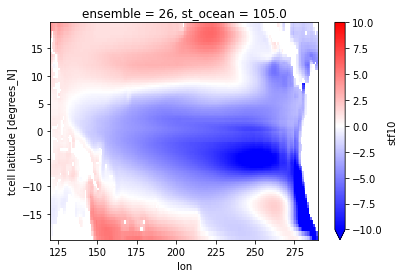

In [36]:
bgcdatvs_allens.stf10.sel(ensemble=26).mean(dim='time').plot(vmin=-10,vmax=10,cmap='bwr') #mmol/m2/day

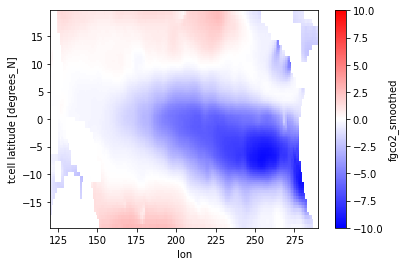

In [37]:
(land_co2.mean(dim='time')).plot(vmin=-10,vmax=10,cmap='bwr')  #gram/m2/day

## Add a few custom functions ive been making.
wrap functions to wrap functions that wrap functions
who wraps the wrapper for the wrapper? 

In [39]:
# return a new DataArray
def xarray_get_trend(dat,input_core_dims='time'):
    '''
    x is time
    y is desired variable
    
    expected time, otherwise input_core_dims='
    Returns Paramaters
    #parameters are [slope, intercept, r_value, p_value, std_err]
    '''
    
    def lin_xarray_linregress(x,y):
        x=pd.to_numeric(x.astype('datetime64[D]'))
        # Wrapper around scipy linregress to use in apply_ufunc
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        return np.array([slope, intercept, r_value, p_value, std_err])
    
    x=dat[input_core_dims]
    y=dat
    stat = xr.apply_ufunc(lin_xarray_linregress, x,y,
                          input_core_dims=[[input_core_dims], [input_core_dims]],
                          output_core_dims=[["parameter"]],
                          vectorize=True,
                          dask="parallelized",
                          output_dtypes=['float64'],
                          output_sizes={"parameter": 5})
    return stat

In [40]:
def xarray_detrend(dat,keep_intercept_values=True,return_trend=False,input_core_dims='time'):
    '''
    For example, if you have a simple linear trend for the mean, calculate the least squares regression 
    line to estimate the growth rate, r. Then subtract the deviations from the least squares fit line 
    (i.e. the differences) from your data.
    https://www.statisticshowto.com/detrend-data
    '''
    def lin_xarray_detrender(x,y,keep_intercept_values=True):
        x=pd.to_numeric(x.astype('datetime64[D]'))
        # Wrapper around scipy linregress to use in apply_ufunc
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        m=slope
        b=intercept
        if keep_intercept_values==True:
            
            # Check intercept x=0. Use mean / median otherwise.
            return b+(y-(m*x + b))
        elif keep_intercept_values==False:
            return y-(m*x + b)
        # Needs to happen inside this function.
        # Ok actually just use the linregress function above and thenb 

    x=dat[input_core_dims]
    y=dat
    #stat=xarray_get_trend(dat,input_core_dims)
    #m=stat.sel(parameter=0) #slope
    #b=stat.sel(parameter=1) #intercept
    #detrend_y=b+(y-(m*x + b))
    # This doesnt seem to work because of shapes.... sure theres a way to broadcast the dimensions together but meh.
    
    detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,
                       input_core_dims=[[input_core_dims], [input_core_dims],[]],
                       output_core_dims=[[input_core_dims]],
                       vectorize=True,
                       dask="parallelized",
                       output_dtypes=['float64'],
                       output_sizes={input_core_dims:len(x)})
    
    return detrended

In [41]:
# This method doesnt do nans and also doesnt keep relative magnitude
#def detrender(da):
#    return xr.apply_ufunc(
#            sps.detrend,
#            da.fillna(-9999),
#            1,
#            'constant',
#            output_dtypes=[da.dtype],
#            dask="parallelized",
#            )
def deseasonaliser(da,keep_relative=True,return_seasonality=False,rolling=False):
    if rolling==True:
        return da.rolling(dim={'time':12}).mean()
    deseasonalised= da.groupby("time.month") - da.groupby("time.month").mean("time")
    seasonality=(da-deseasonalised)
    base_seasonality=seasonality-seasonality.mean(dim='time')
    detrended_season_removed=da-base_seasonality
    if keep_relative==True:
        returns=[detrended_season_removed]
    else:
        returns=[deseasonalised]
    return returns[0]


 #(dim='time')

In [42]:
rey_sst.rolling(dim={'time':12}).mean()

<xarray.DataArray 'sst' (time: 456, lat: 98, lon: 170)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [28.62118612, 28.63356385, 28.74193346, ..., 28.12889099,
         28.05491546, 27.99095107],
        [28.47651753, 28.50835513, 28.58065707, ..., 28.22900924,
         28.04639566, 27.94809546],
        [28.31238989, 28.367949  , 28.39408996, ..., 28.25721884,
         27.99959354, 27.90898687]],

       [[27.26176232, 27.24460897, 27.09575192, ..., 20.450659  ,
         20.32494523, 20.11013992],
        [27.40473288, 27.38052725, 27.35797154, ..., 20.41411484,
         20.28904246, 20.12424472],
        [27.62067339, 27.60433847, 27.75414478, ..., 20.14787803,
         20.15664642, 20.12258352],
        ...,
        [28.53322844, 28.57222901, 28.71538884, ..., 28.16322363,
         28.08845669, 28.02670054],
        [28.39365036, 28.43914926, 28.53710713, ..., 28.2572766 ,
         28.07542418, 27.97944028],
        [28.24106297, 28.30579541, 28.34861672, ..., 28.27009925,
         28.01259396, 27.93007373]]])
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2019-12-01
  * lon      (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat      (lat) float64 -19.36 -18.59 -17.85 -17.15 ... 17.85 18.59 19.36

In [43]:
#Ok how does this error look through time for different parts of the Pacific.
def plot_pacific_boxes(var_a,
                 var_b,
                 var_a_name,
                 var_b_name,
                 units,
                 title,
                 var_c=None,
                 var_d=None,
                 var_c_name=None,
                 var_d_name=None,
                 error=False,
                 sdate='1990-01-01',
                 edate='2020-01-01',
                 detrend=False,
                 deseasonalise=False,
                 plot_decomposition=False,
                 keep_intercept_values=True,
                 rolling=False):

    labels=['Whole EqPac',
           'SouthEast EqPac',
           'NorthEast EqPac',
            'All East EqPac',
            'Central EqPac',
            'Dateline EqPac',
            'FarWest EqPac']

    locs=[[-15,15,150,275],
          [-15,0,225,250],
          [0,15,225,250],
          [-15,15,225,250],
          [-15,15,200,225],
          [-15,15,175,200],
          [-15,15,150,175]]

    # terrible solution but works to plot all
    var_a_actual=var_a
    if var_b is not None:var_b_actual=var_b
    
    if detrend==True:
        var_a_detrended=xarray_detrend(var_a_actual,keep_intercept_values=keep_intercept_values)
        if var_b is not None:var_b_detrended=xarray_detrend(var_b_actual,keep_intercept_values=keep_intercept_values)
            
        var_a_actual=var_a_detrended
        if var_b is not None:var_b_actual=var_b_detrended
        if var_c is not None:var_c=xarray_detrend(var_c,keep_intercept_values=keep_intercept_values)
        if var_d is not None:var_d=xarray_detrend(var_d,keep_intercept_values=keep_intercept_values)
        
    if deseasonalise==True:
        var_a_deseasonalised=deseasonaliser(var_a_actual,rolling=rolling)
        if var_b is not None:var_b_deseasonalised=deseasonaliser(var_b_actual,rolling=rolling)
        
        var_a_actual=var_a_deseasonalised
        if var_b is not None:var_b_actual=var_b_deseasonalised
        
        if var_c is not None:var_c=deseasonaliser(var_c,rolling=rolling)
        if var_d is not None:var_d=deseasonaliser(var_d,rolling=rolling)
        
    plt.figure(figsize=(20,12))

    
    for i,latlon in enumerate(locs):
        print(i)

        if i==0:
            ax=plt.subplot(3,1,1)
        else:
            ax=plt.subplot(3,3,3+i)



            
        var_a_loc=var_a_actual.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon'])
        plt.plot(var_a_loc.time,var_a_loc,c='k',linewidth=2)
        
        if var_b is not None: 
            var_b_loc=var_b_actual.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon'])
            plt.plot(var_b_loc.time,var_b_loc,c='r',linewidth=2)

        leglabels=[None,None,None,None]
        if plot_decomposition==True:
            
            if detrend==True:
                if keep_intercept_values!=False:
                    # Plot the raw vesion because we do plot the 
                    plt.plot(var_a_loc.time,var_a.sel(
                        lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon']),c='k',linewidth=2,linestyle='--')
                    leglabels[0]='Raw'
                    plot_tr=True
                #if plot_tr==True:
                #    m, b, _ = stats.linregress(x, y)
                #    detrend_y=y-(m*x + b)
                
                if var_b is not None:plt.plot(var_b_loc.time,var_b.sel(
                    lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon']),c='r',linewidth=2,linestyle='--')
                    #leglabels[1]='Raw'
                    
                
            if deseasonalise==True:
                # Assumes Detrended is already On
                plt.plot(var_a_loc.time,var_a_detrended.sel(
                    lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon']),c='k',linewidth=2,linestyle=':')
                leglabels[1]='Detrended'
                if var_b is not None: plt.plot(var_b_loc.time,var_b_detrended.sel(
                    lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon']),c='r',linewidth=2,linestyle=':')

                
        if var_c is not None:
            var_c_loc=((var_c).sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon']))
            plt.plot(var_c_loc.time,var_c_loc,c='g',linewidth=2)
         
        if var_d is not None:
            var_d_loc=((var_d).sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon']))
            plt.plot(var_d_loc.time,var_d_loc,c='m',linewidth=2)
            
        legs=[var_a_name,var_b_name,var_c_name,var_d_name]
        for l in leglabels:
            legs.append(l)
        ax.legend(legs)
        ax.set_xlim([np.datetime64(sdate),np.datetime64(edate)])
        ax.set_ylabel(units)
        #ax.set_title('CO2 flux comparisons')
        ax.set_title(title+labels[i])

    plt.tight_layout()
    plt.show()

#UNITS surface_phy=mmol/m^3
# output should me mg Chl M3

In [44]:
# Convert Data for plotting
sst_cafe=bgcdatvs_allens.sst.sel(ensemble=26).sel(time=slice('2000-01-01','2020-01-01'))
sst_rey=rey_sst.sel(time=slice('1990-01-01','2020-01-01'))
co2_cafe=bgcdatvs_allens.stf10.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01'))
co2_land=land_co2.sel(time=slice('1990-01-01','2020-01-01'))

/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,


0
1
2
3
4
5
6


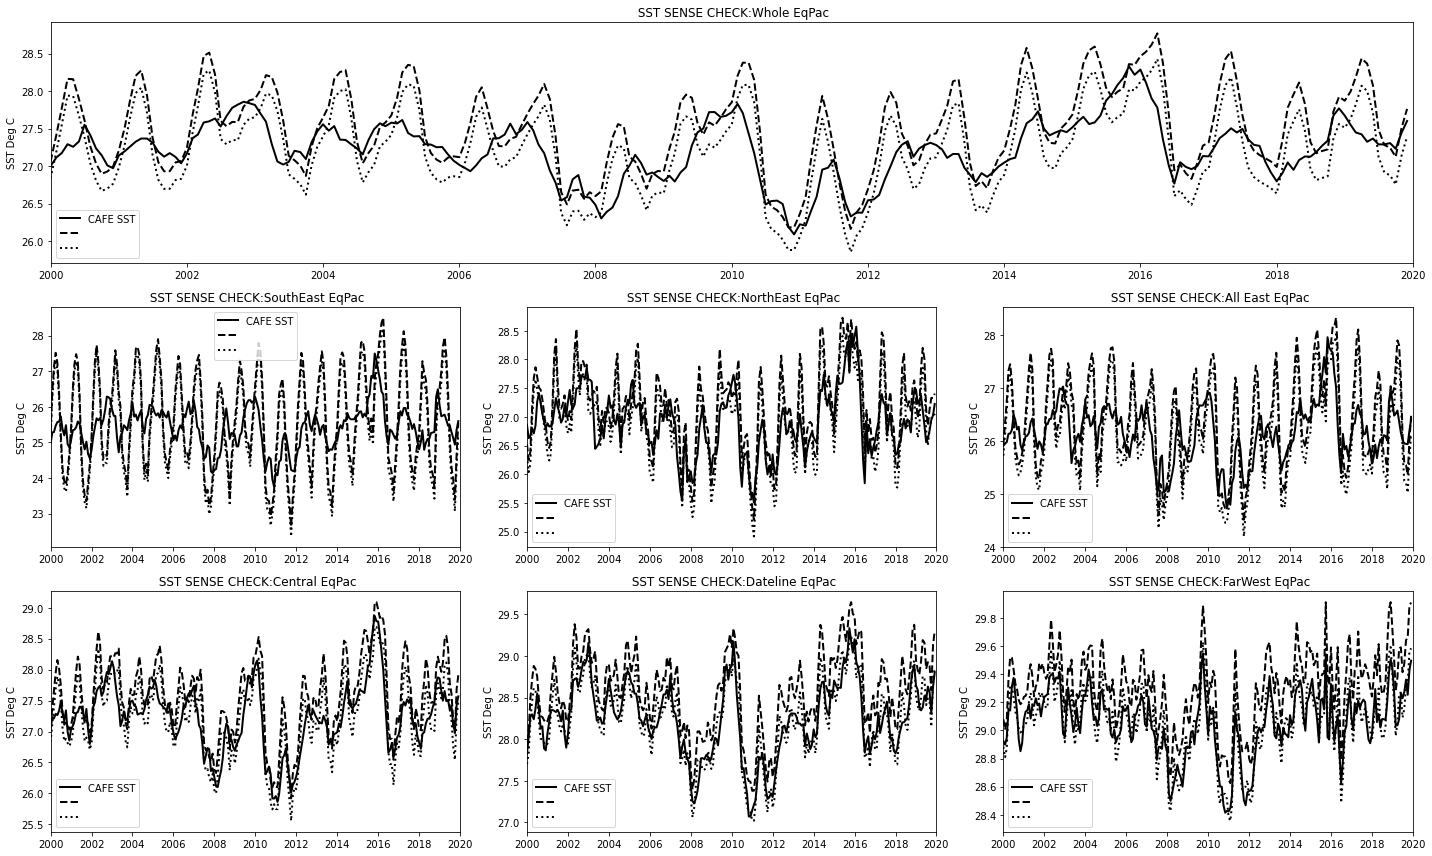

In [45]:
# Good test case
plot_pacific_boxes(var_a=sst_cafe,
                   var_b=None,
                   var_a_name='CAFE SST',
                   var_b_name=None,
                   units='SST Deg C',
                   title=' SST SENSE CHECK:',sdate='2000-01-01',
                   detrend=True,deseasonalise=True,plot_decomposition=True,keep_intercept_values=True)

/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,


0
1
2
3
4
5
6


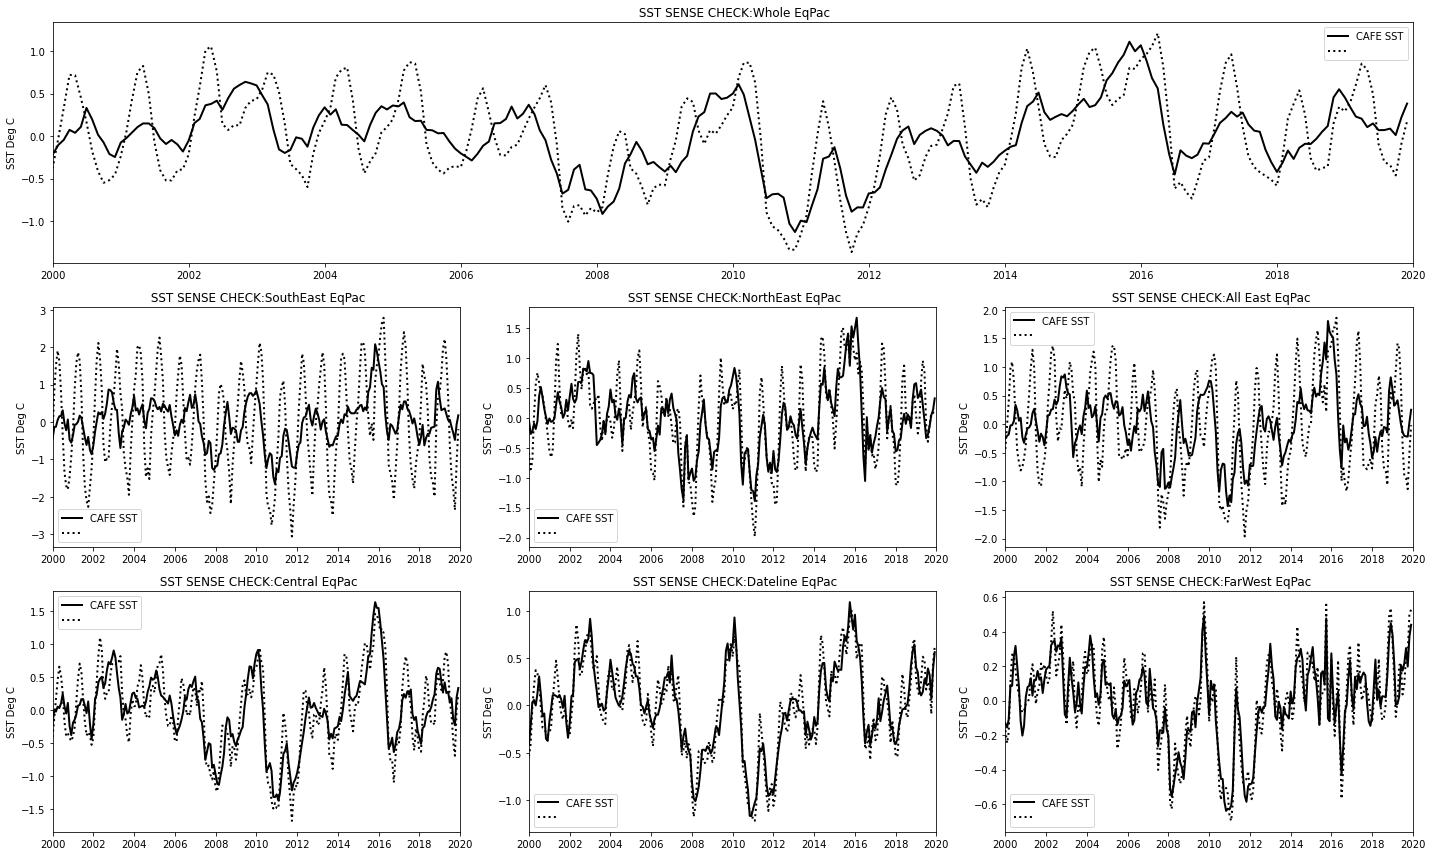

In [46]:
# Good test case
plot_pacific_boxes(var_a=sst_cafe,
                   var_b=None,
                   var_a_name='CAFE SST',
                   var_b_name=None,
                   units='SST Deg C',
                   title=' SST SENSE CHECK:',sdate='2000-01-01',
                   detrend=True,deseasonalise=True,plot_decomposition=True,keep_intercept_values=False,rolling=False)

/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,


0
1
2
3
4
5
6


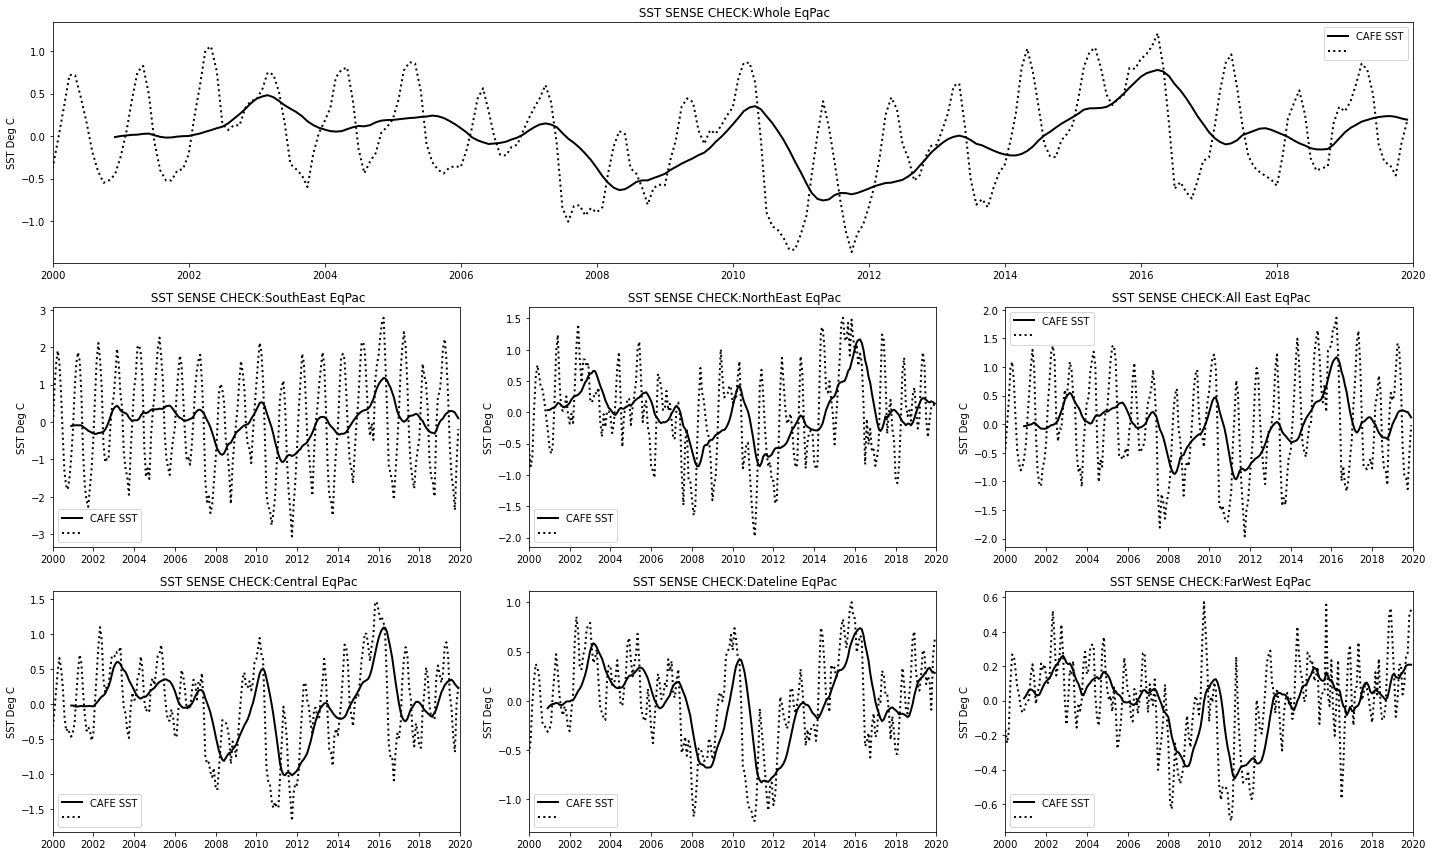

In [47]:
# Good test case
plot_pacific_boxes(var_a=sst_cafe,
                   var_b=None,
                   var_a_name='CAFE SST',
                   var_b_name=None,
                   units='SST Deg C',
                   title=' SST SENSE CHECK:',sdate='2000-01-01',
                   detrend=True,deseasonalise=True,plot_decomposition=True,keep_intercept_values=False,rolling=True)

In [48]:
rodenbeck_co2

<xarray.DataArray 'co2flux_ocean' (time: 768, lat: 98, lon: 170)>
[12794880 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1957-01-01 1957-02-01 ... 2020-12-01
  * lon      (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat      (lat) float64 -19.36 -18.59 -17.85 -17.15 ... 17.85 18.59 19.36

In [49]:
rodenbeck1_CO2=xr.open_dataset('../../rxm599/obs/oc_v2021_daily.nc')

In [50]:
#rodenbeck1_CO2

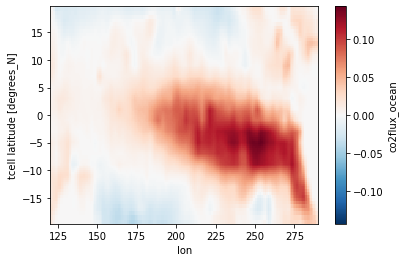

In [51]:
rodenbeck_co2.mean(dim='time').plot()

/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,
/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,
/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,


0
1
2
3
4
5
6


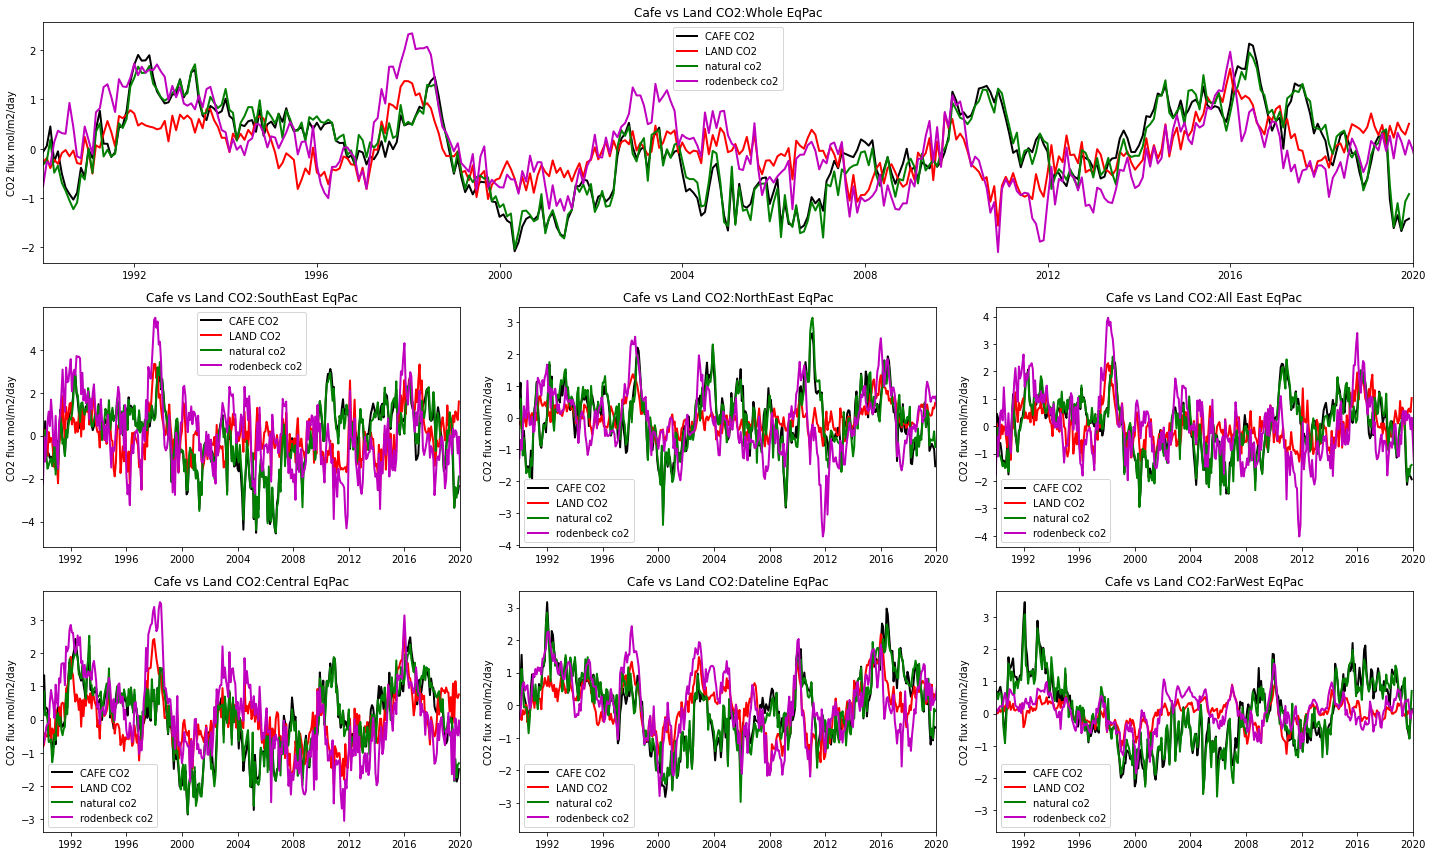

In [52]:
plot_pacific_boxes(var_a=bgcdatvs_allens.stf10.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01')),
                   var_b=co2_land,
                   var_c=bgcdatvs_allens.stf07.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01')),
                   var_d=(rodenbeck_co2*-1000)/12,
                   var_a_name='CAFE CO2',
                   var_b_name='LAND CO2',
                   var_c_name='natural co2',
                   var_d_name='rodenbeck co2',
                   units='CO2 flux mol/m2/day',
                   title='Cafe vs Land CO2:',detrend=True,deseasonalise=True,keep_intercept_values=False)

In [53]:
co2_cafe=bgcdatvs_allens.stf10.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01'))
co2_land=land_co2.sel(time=slice('1990-01-01','2020-01-01'))

0
1
2
3
4
5
6


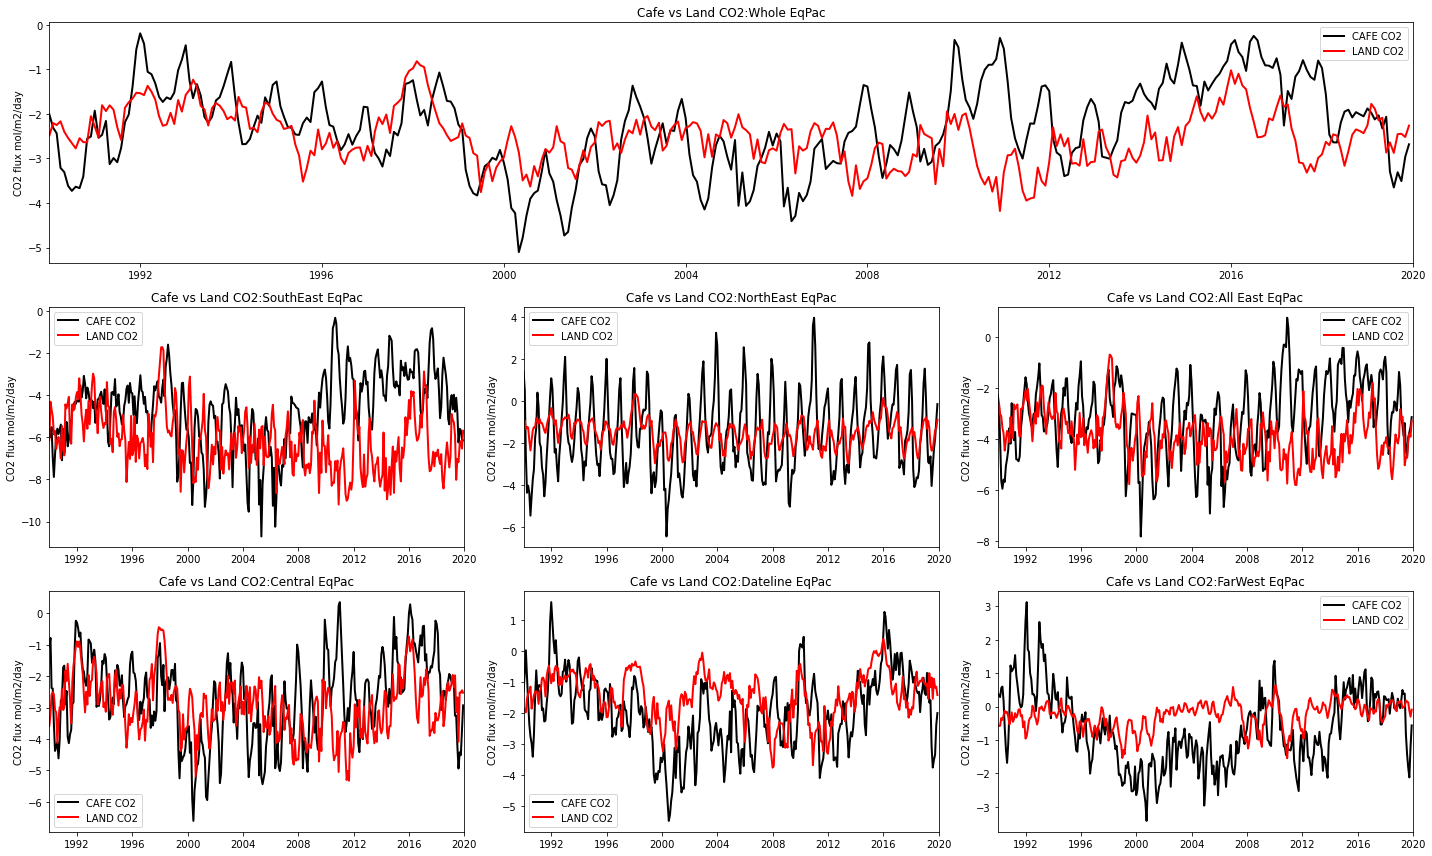

In [54]:
plot_pacific_boxes(var_a=co2_cafe,
                   var_b=co2_land,
                   var_a_name='CAFE CO2',
                   var_b_name='LAND CO2',
                   units='CO2 flux mol/m2/day',
                   title='Cafe vs Land CO2:',keep_intercept_values=False)

/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,
/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,


0
1
2
3
4
5
6


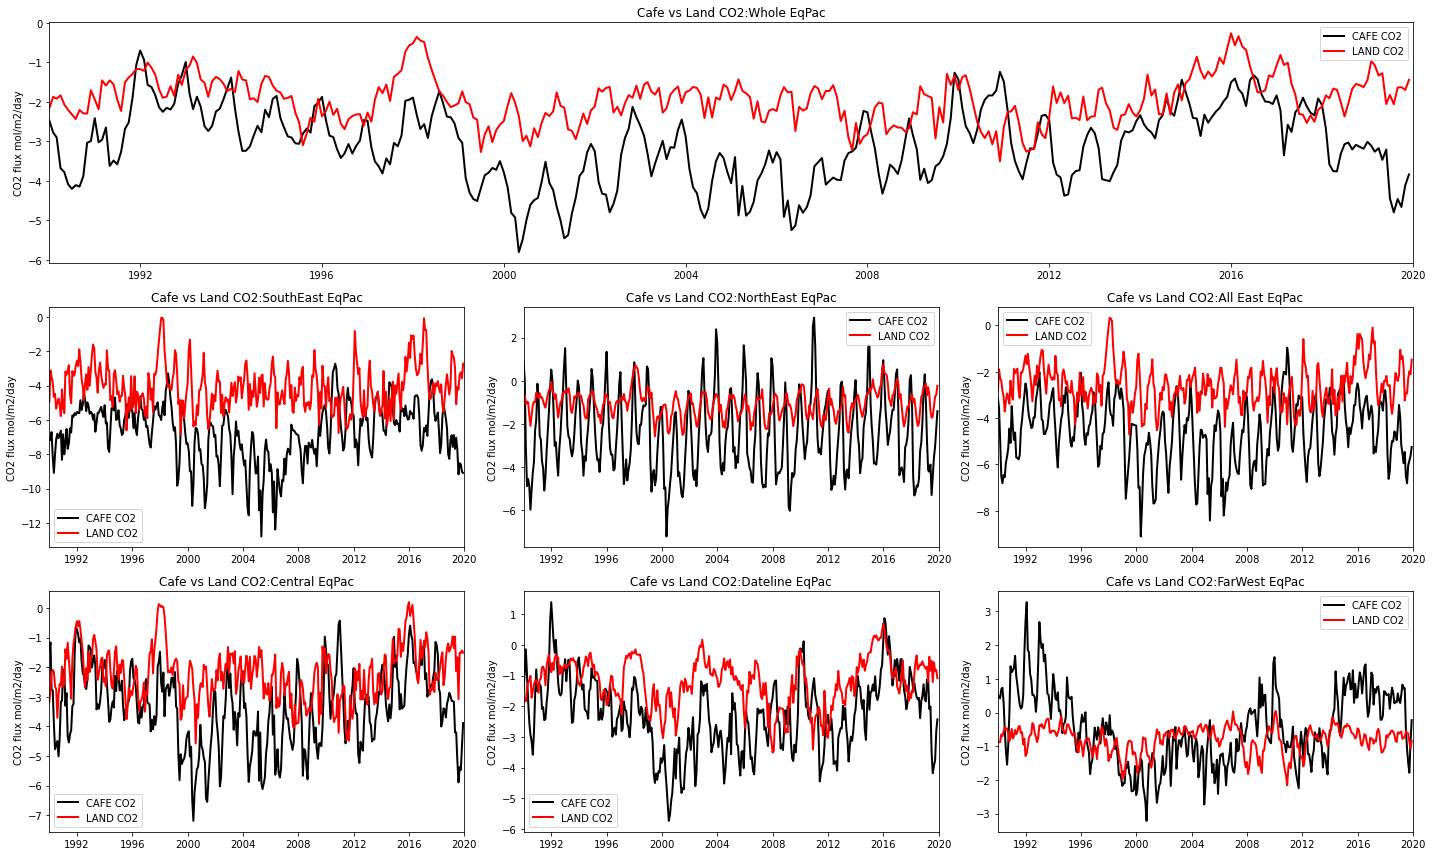

In [55]:
plot_pacific_boxes(var_a=co2_cafe,
                   var_b=co2_land,
                   var_a_name='CAFE CO2',
                   var_b_name='LAND CO2',
                   units='CO2 flux mol/m2/day',
                   title='Cafe vs Land CO2:',detrend=True)

/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,
/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,


0
1
2
3
4
5
6


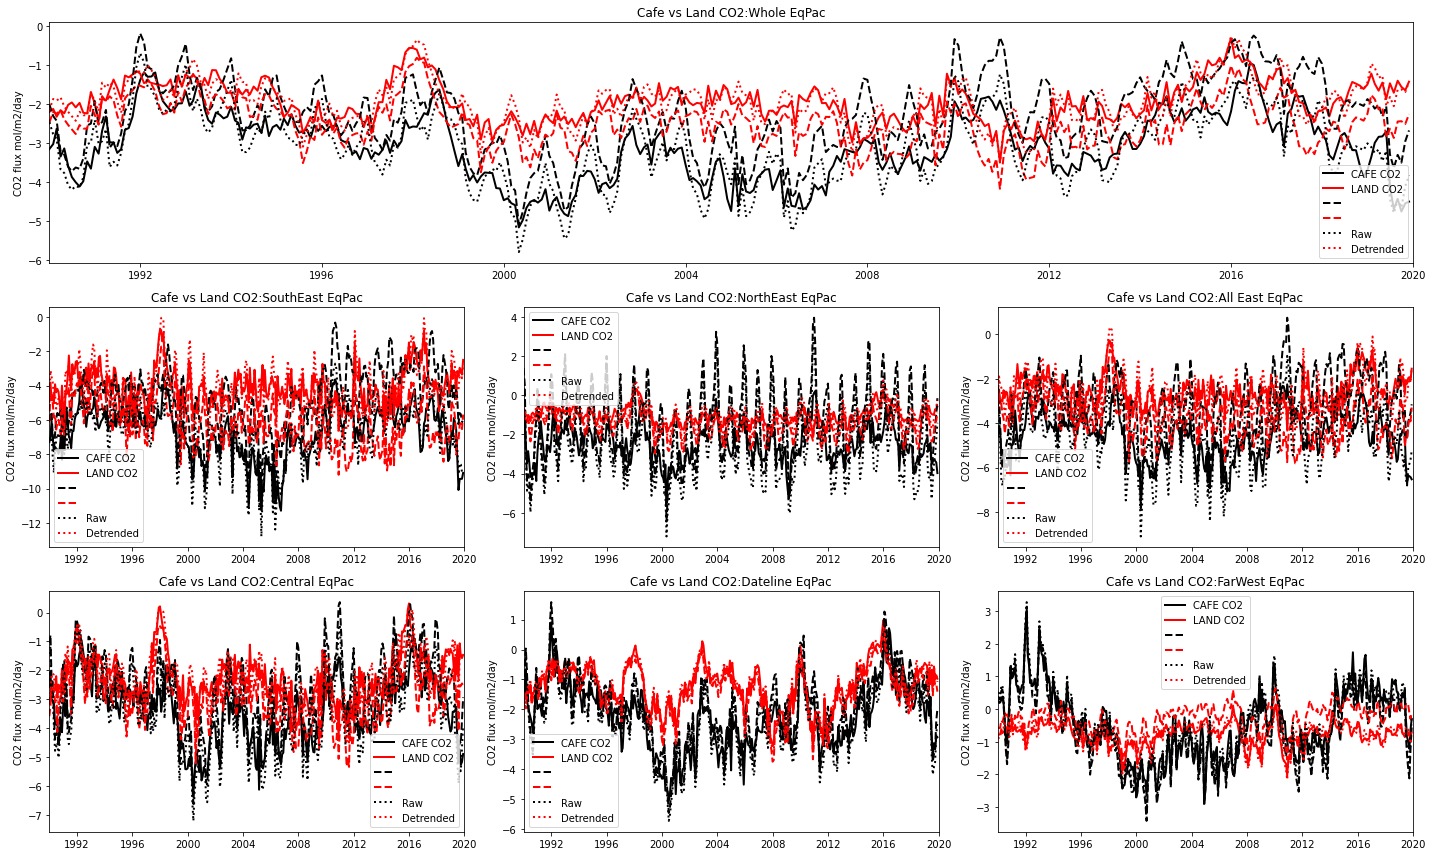

In [56]:
plot_pacific_boxes(var_a=co2_cafe,
                   var_b=co2_land,
                   var_a_name='CAFE CO2',
                   var_b_name='LAND CO2',
                   units='CO2 flux mol/m2/day',
                   title='Cafe vs Land CO2:',detrend=True,deseasonalise=True,plot_decomposition=True)

/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,
/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,


0
1
2
3
4
5
6


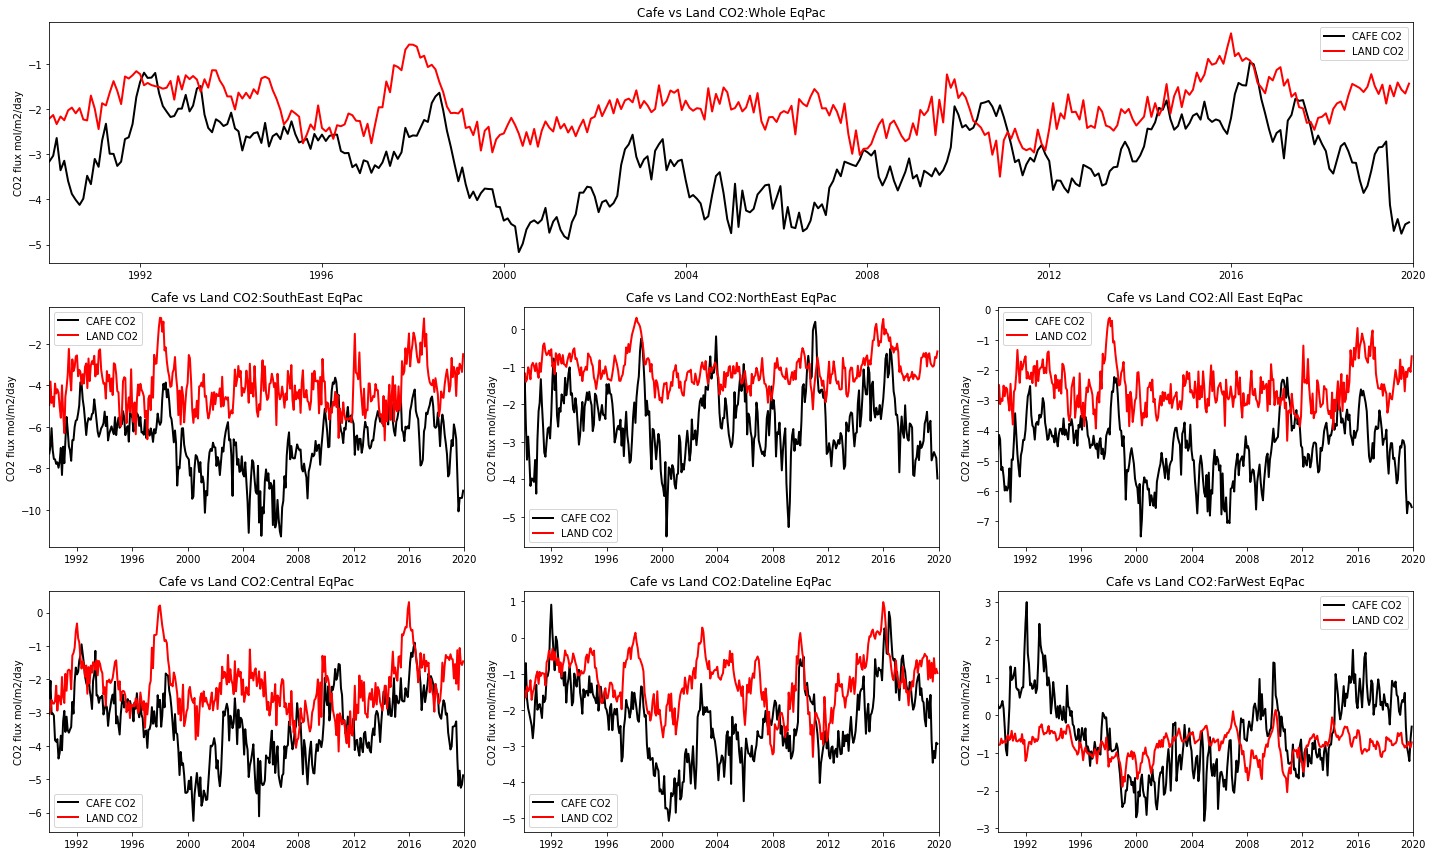

In [57]:
plot_pacific_boxes(var_a=co2_cafe,
                   var_b=co2_land,
                   var_a_name='CAFE CO2',
                   var_b_name='LAND CO2',
                   units='CO2 flux mol/m2/day',
                   title='Cafe vs Land CO2:',
                   detrend=True,
                   deseasonalise=True)

/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,
/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,


0
1
2
3
4
5
6


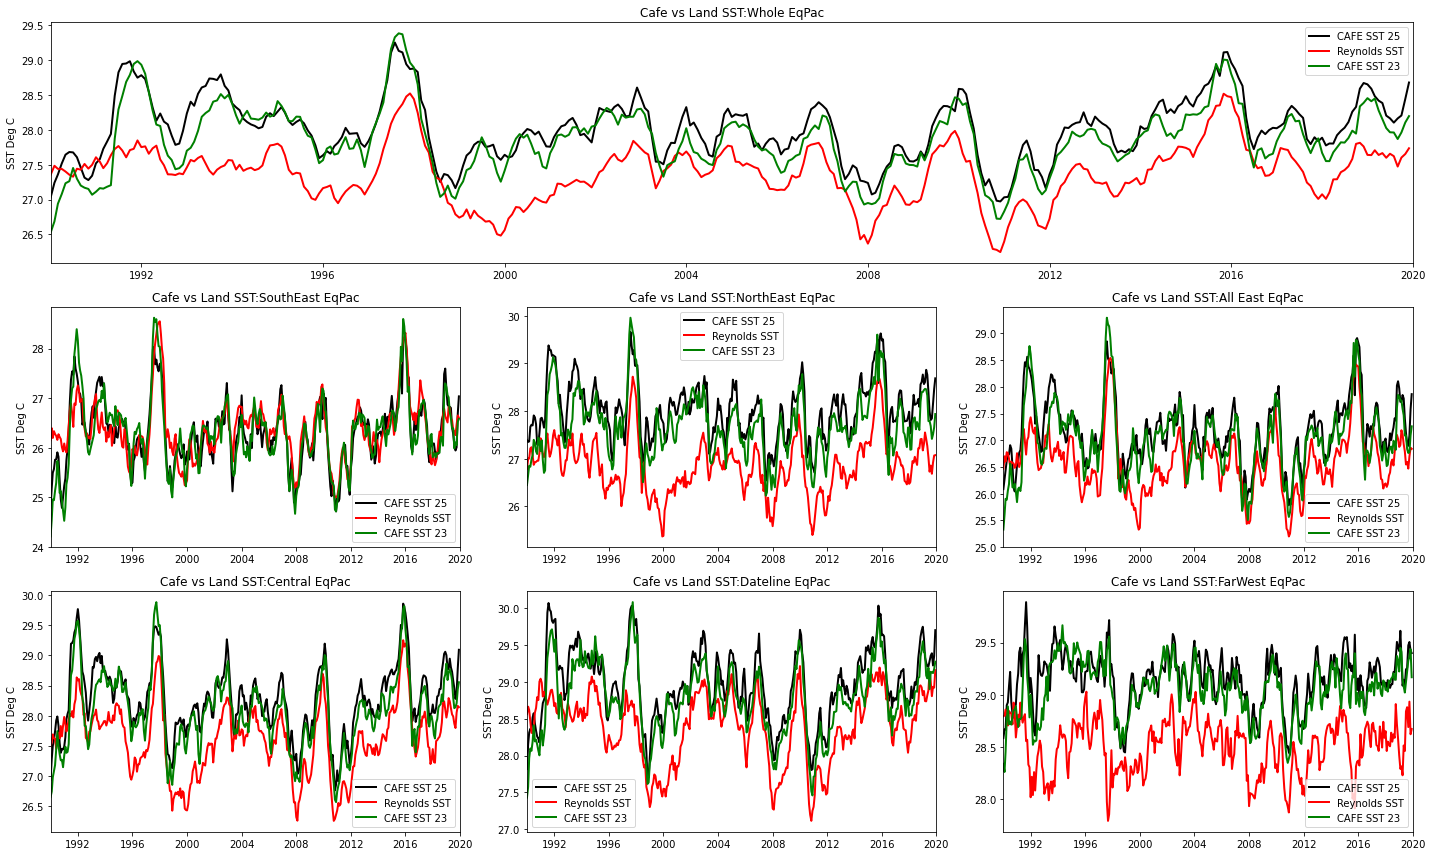

In [58]:
sst_cafe=bgcdatvs_allens.sst.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01'))
sst_rey=rey_sst.sel(time=slice('1990-01-01','2020-01-01'))

plot_pacific_boxes(var_a=bgcdatvs_allens.sst.sel(ensemble=25).sel(time=slice('1990-01-01','2020-01-01')),
                   var_b=sst_rey,
                   var_c=bgcdatvs_allens.sst.sel(ensemble=23).sel(time=slice('1990-01-01','2020-01-01')),
                   var_a_name='CAFE SST 25',
                   var_b_name='Reynolds SST',
                   var_c_name='CAFE SST 23',
                   units='SST Deg C',
                   title='Cafe vs Land SST:',
                   detrend=True,deseasonalise=True,keep_intercept_values=True)

/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,
/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,


0
1
2
3
4
5
6


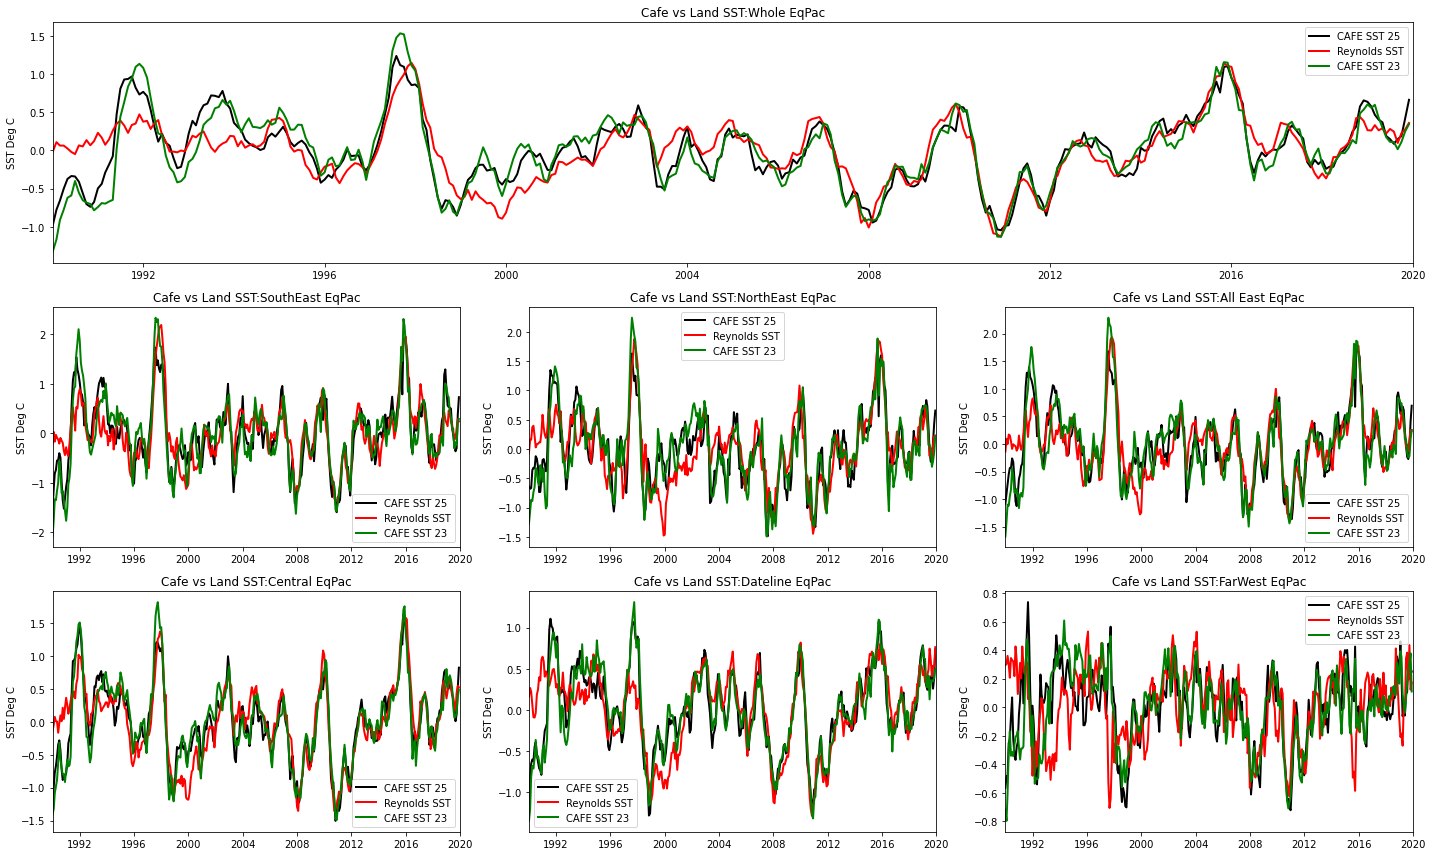

In [59]:
sst_cafe=bgcdatvs_allens.sst.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01'))
sst_rey=rey_sst.sel(time=slice('1990-01-01','2020-01-01'))

plot_pacific_boxes(var_a=bgcdatvs_allens.sst.sel(ensemble=25).sel(time=slice('1990-01-01','2020-01-01')),
                   var_b=sst_rey,
                   var_c=bgcdatvs_allens.sst.sel(ensemble=23).sel(time=slice('1990-01-01','2020-01-01')),
                   var_a_name='CAFE SST 25',
                   var_b_name='Reynolds SST',
                   var_c_name='CAFE SST 23',
                   units='SST Deg C',
                   title='Cafe vs Land SST:',
                   detrend=True,deseasonalise=True,keep_intercept_values=False)

/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,
/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,


0
1
2
3
4
5
6


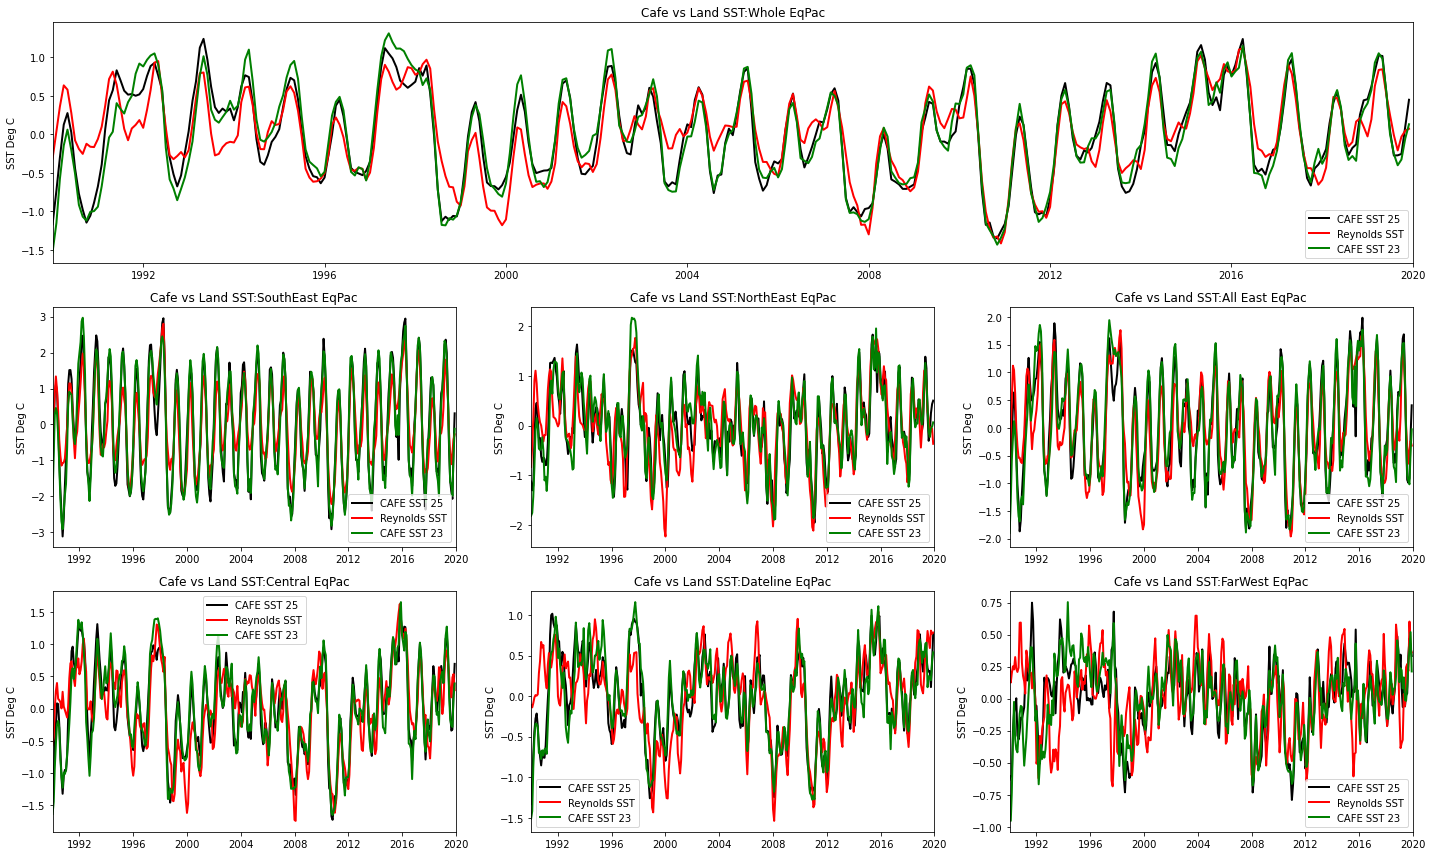

In [60]:
sst_cafe=bgcdatvs_allens.sst.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01'))
sst_rey=rey_sst.sel(time=slice('1990-01-01','2020-01-01'))

plot_pacific_boxes(var_a=bgcdatvs_allens.sst.sel(ensemble=25).sel(time=slice('1990-01-01','2020-01-01')),
                   var_b=sst_rey,
                   var_c=bgcdatvs_allens.sst.sel(ensemble=23).sel(time=slice('1990-01-01','2020-01-01')),
                   var_a_name='CAFE SST 25',
                   var_b_name='Reynolds SST',
                   var_c_name='CAFE SST 23',
                   units='SST Deg C',
                   title='Cafe vs Land SST:',
                   detrend=True,deseasonalise=False,keep_intercept_values=False)

/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,
/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,


0
1
2
3
4
5
6


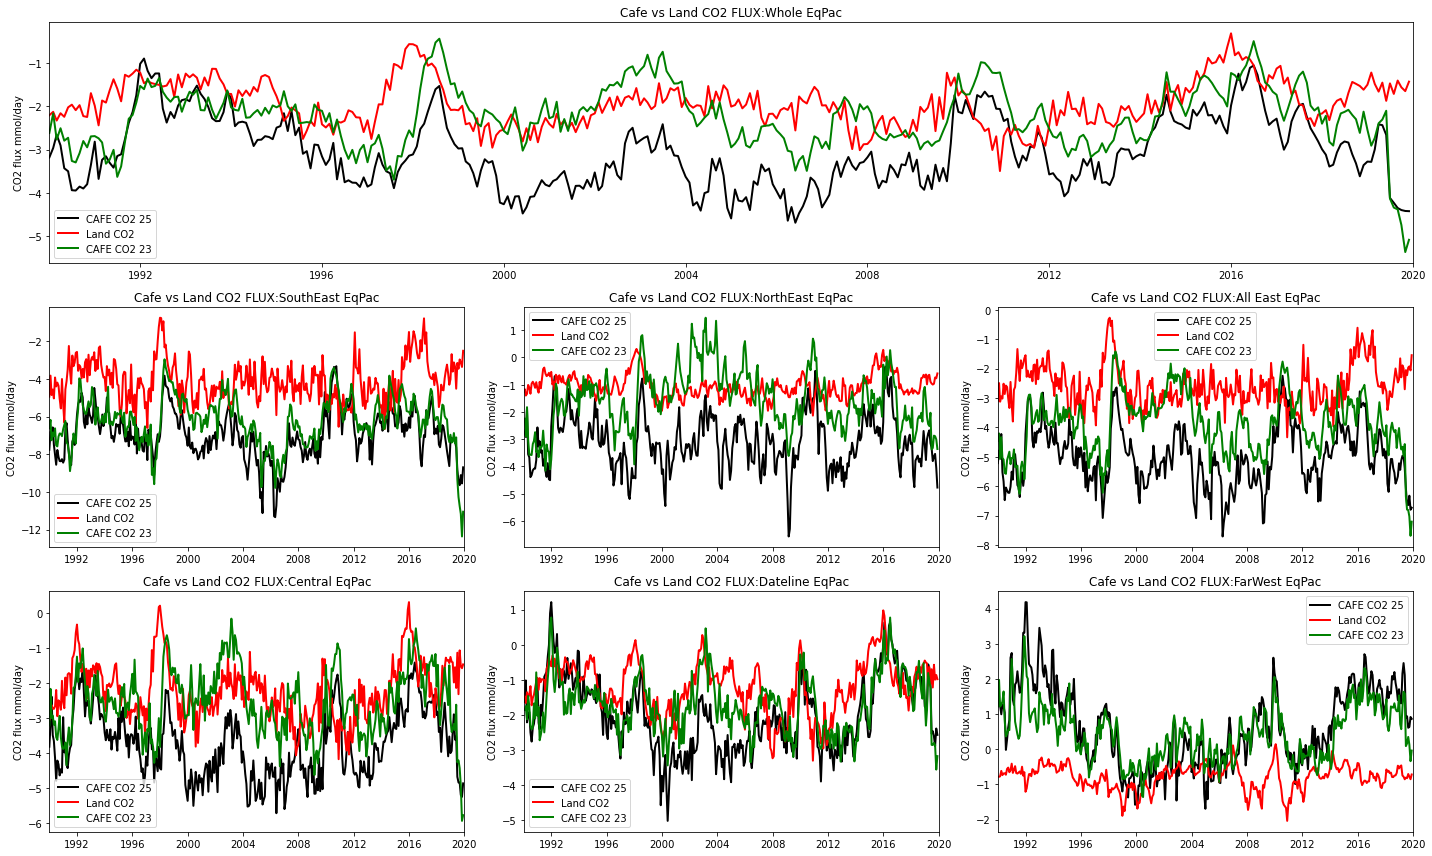

In [61]:
sst_cafe=bgcdatvs_allens.sst.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01'))
sst_rey=rey_sst.sel(time=slice('1990-01-01','2020-01-01'))

plot_pacific_boxes(var_a=bgcdatvs_allens.stf10.sel(ensemble=25).sel(time=slice('1990-01-01','2020-01-01')),
                   var_b=co2_land,
                   var_c=bgcdatvs_allens.stf10.sel(ensemble=23).sel(time=slice('1990-01-01','2020-01-01')),
                   var_a_name='CAFE CO2 25',
                   var_b_name='Land CO2',
                   var_c_name='CAFE CO2 23',
                   units='CO2 flux mmol/day',
                   title='Cafe vs Land CO2 FLUX:',
                   detrend=True,deseasonalise=True,keep_intercept_values=True)

/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,
/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,


0
1
2
3
4
5
6


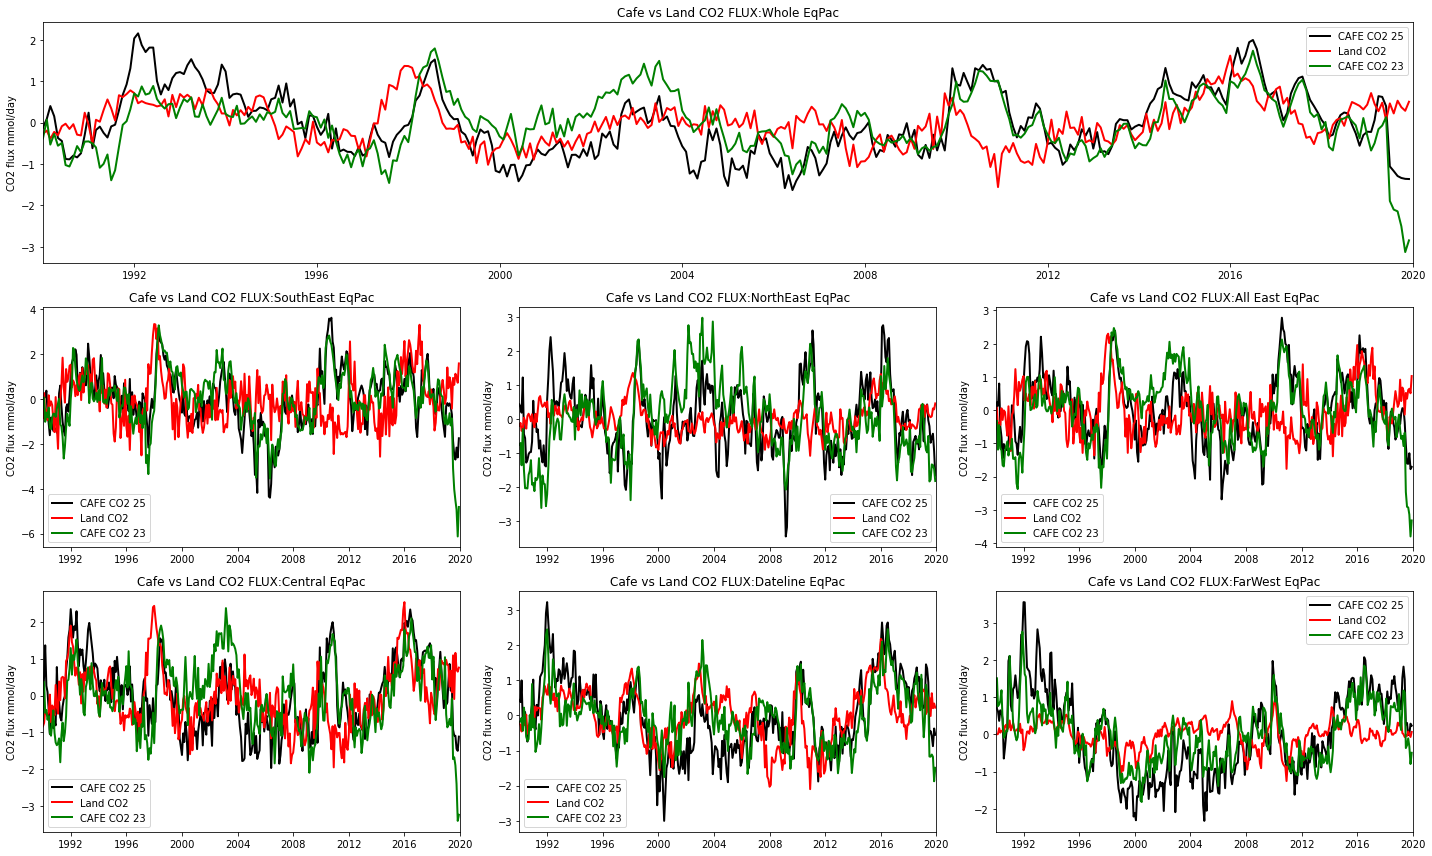

In [62]:
sst_cafe=bgcdatvs_allens.sst.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01'))
sst_rey=rey_sst.sel(time=slice('1990-01-01','2020-01-01'))

plot_pacific_boxes(var_a=bgcdatvs_allens.stf10.sel(ensemble=25).sel(time=slice('1990-01-01','2020-01-01')),
                   var_b=co2_land,
                   var_c=bgcdatvs_allens.stf10.sel(ensemble=23).sel(time=slice('1990-01-01','2020-01-01')),
                   var_a_name='CAFE CO2 25',
                   var_b_name='Land CO2',
                   var_c_name='CAFE CO2 23',
                   units='CO2 flux mmol/day',
                   title='Cafe vs Land CO2 FLUX:',
                   detrend=True,deseasonalise=True,keep_intercept_values=False)

/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,
/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,


0
1
2
3
4
5
6


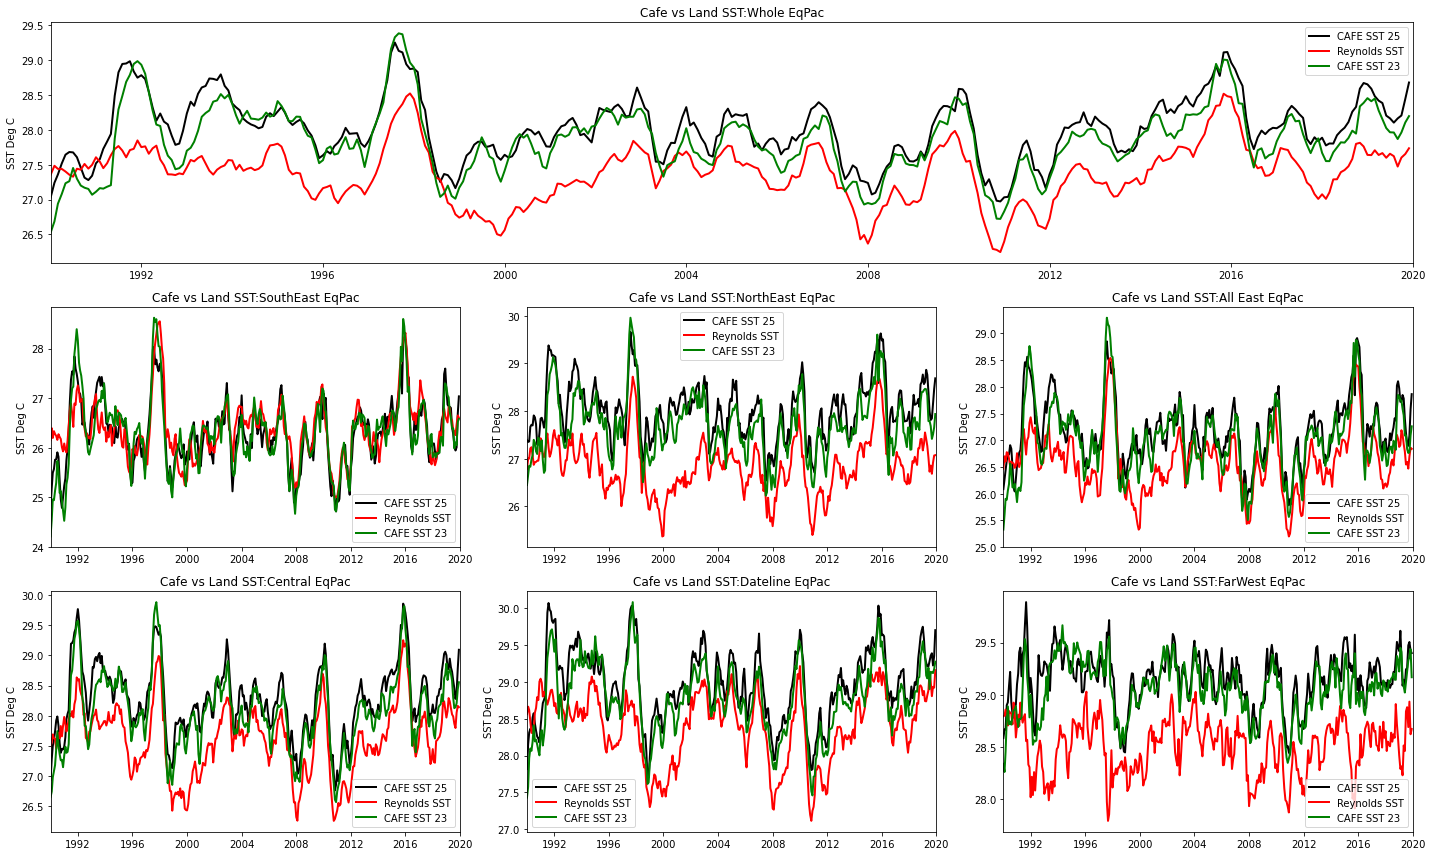

In [63]:
sst_cafe=bgcdatvs_allens.sst.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01'))
sst_rey=rey_sst.sel(time=slice('1990-01-01','2020-01-01'))

plot_pacific_boxes(var_a=bgcdatvs_allens.sst.sel(ensemble=25).sel(time=slice('1990-01-01','2020-01-01')),
                   var_b=sst_rey,
                   var_c=bgcdatvs_allens.sst.sel(ensemble=23).sel(time=slice('1990-01-01','2020-01-01')),
                   var_a_name='CAFE SST 25',
                   var_b_name='Reynolds SST',
                   var_c_name='CAFE SST 23',
                   units='SST Deg C',
                   title='Cafe vs Land SST:',
                   detrend=True,deseasonalise=True)

0
1
2
3
4
5
6


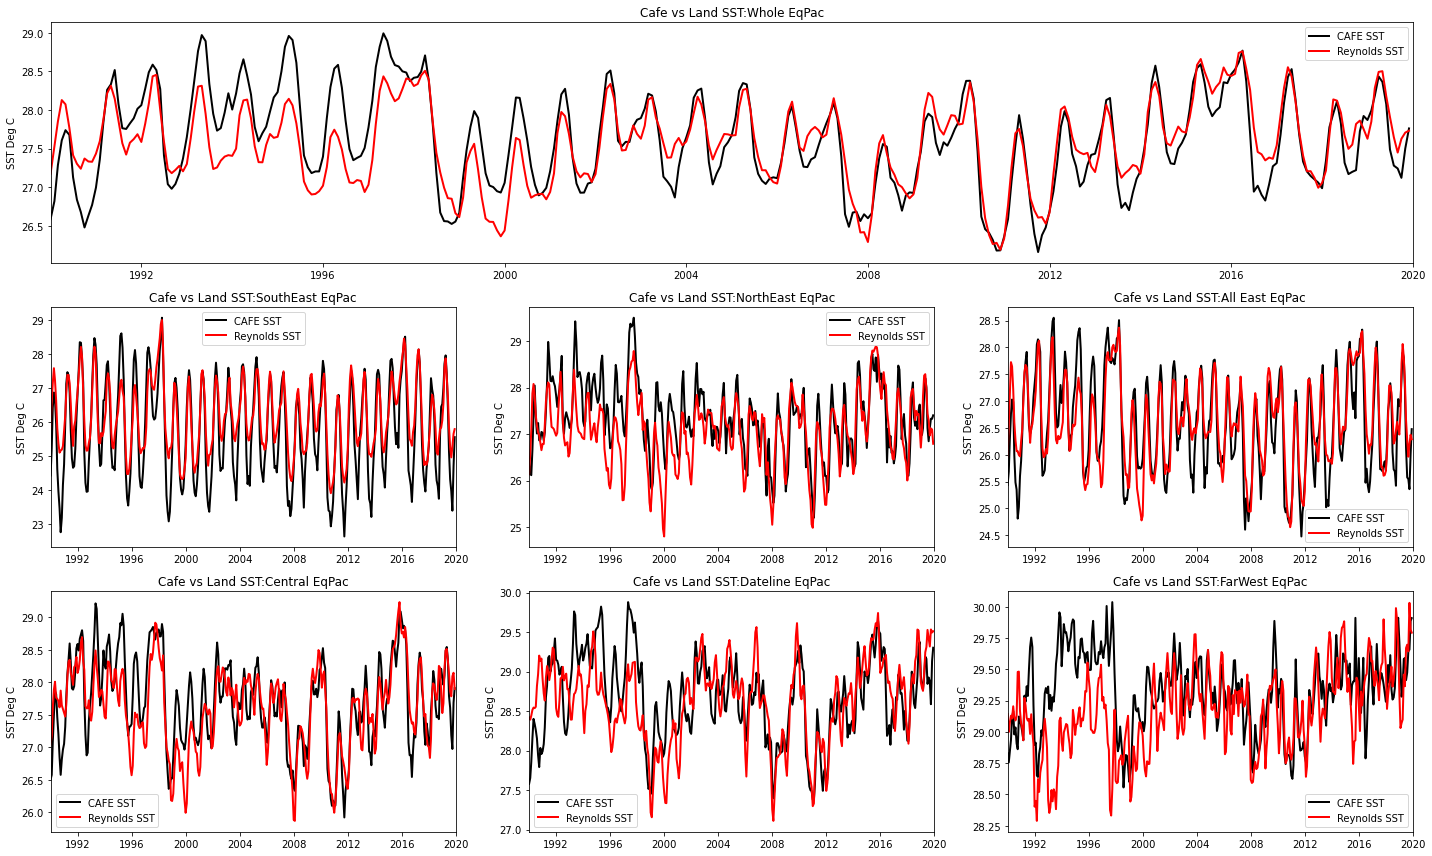

In [64]:
sst_cafe=bgcdatvs_allens.sst.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01'))
sst_rey=rey_sst.sel(time=slice('1990-01-01','2020-01-01'))

plot_pacific_boxes(var_a=sst_cafe,
                   var_b=sst_rey,
                   var_a_name='CAFE SST',
                   var_b_name='Reynolds SST',
                   units='SST Deg C',
                   title='Cafe vs Land SST:',
                   detrend=False)#,deseasonalise=True)

In [65]:
np1_cafe_25=bgcdatvs_allens.det_export.sel(ensemble=25).sel(time=slice('1990-01-01','2020-01-01'))*6.625
np1_cafe_23=bgcdatvs_allens.det_export.sel(ensemble=23).sel(time=slice('1990-01-01','2020-01-01'))*6.625
np2_cafe=bgcdatvs_allens.trim_export_2d.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01'))*6.625
np_dat=(np_obs.sel(time=slice('1990-01-01','2020-01-01')))

0
1
2
3
4
5
6


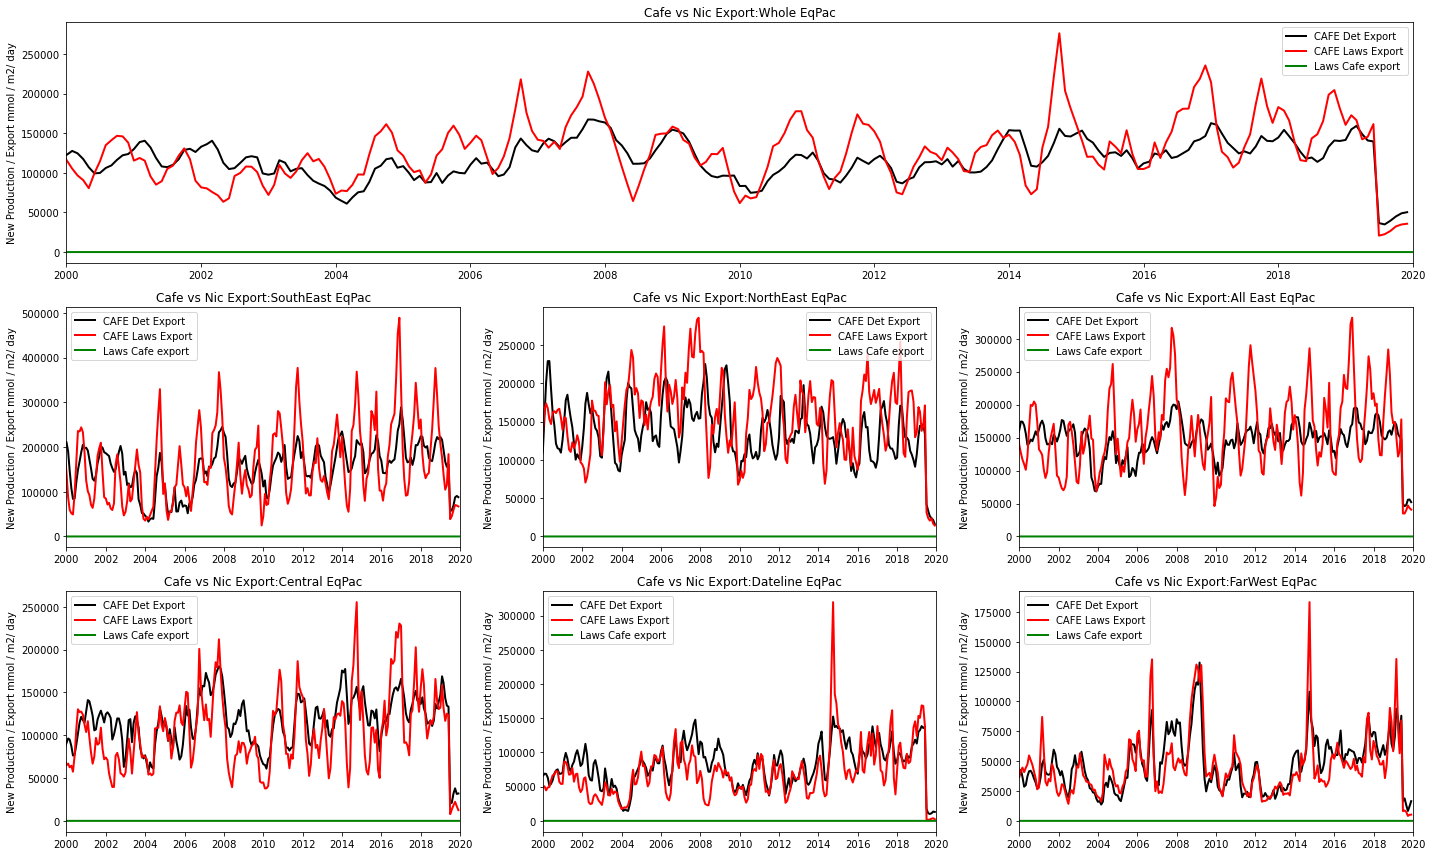

In [67]:

plot_pacific_boxes(var_a=np1_cafe_25,
                   var_b=np1_cafe_23,
                   var_c=np_dat,
                   var_a_name='CAFE Det Export',
                   var_b_name='CAFE Laws Export',
                   var_c_name='Laws Cafe export',
                   units='New Production / Export mmol / m2/ day',
                   title='Cafe vs Nic Export:',
                   sdate='2000-01-01')#,detrend=True,deseasonalise=True)

In [68]:
np1_cafe=bgcdatvs_allens.nics_export.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01'))*6.625
np2_cafe=bgcdatvs_allens.trim_export_2d.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01'))*6.625
np_dat=(np_obs.sel(time=slice('1990-01-01','2020-01-01')))

AttributeError: 'Dataset' object has no attribute 'nics_export'

In [ ]:
#land_co2
#rey_sst

#sst #regrid?
#npp CAFE
# *fr.laws2

In [ ]:
# Seasonality?

In [ ]:
# Convert Data for plotting
sst_cafe=bgcdatvs_allens.sst.sel(time=slice('2000-01-01','2020-01-01'))
sst_rey=rey_sst.sel(time=slice('2000-01-01','2020-01-01'))
co2_cafe=bgcdatvs_allens.stf10.sel(time=slice('2000-01-01','2020-01-01'))
co2_land=land_co2.sel(time=slice('2000-01-01','2020-01-01'))

In [ ]:
#sst_cafe
#sst_rey

In [ ]:
npp_cafe_25=bgcdatvs_allens.pprod_gross_2d.sel(ensemble=25).sel(time=slice('1990-01-01','2020-01-01'))*6.625
npp_cafe_23=bgcdatvs_allens.pprod_gross_2d.sel(ensemble=23).sel(time=slice('1990-01-01','2020-01-01'))*6.625
plot_pacific_boxes(var_a=npp_cafe_25,
                   var_b=npp_cafe_23,
                   var_c=npp.sel(time=slice('1990-01-01','2020-01-01'))/12,
                   var_a_name='CAFE GPP 25',
                   var_b_name='CAFE GPP 23',
                   var_c_name='Cafe NPP',
                   units='New Production / Export mmol / m2/ day',
                   title='Cafe vs Nic Export:',
                   sdate='2000-01-01',detrend=True,deseasonalise=True,keep_intercept_values=False)

In [ ]:
np2_cafe=bgcdatvs_allens.trim_export_2d.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01'))*6.625
np_dat=(np_obs.sel(time=slice('1990-01-01','2020-01-01')))

In [ ]:
sst_rey.groupby('time.month').mean().mean(dim=['lat','lon']).plot()

In [ ]:
plt.figure(figsize=(15,8))
for i in np.arange(15,30):
    sst_cafe.groupby('time.month').mean().mean(dim=['lat','lon']).sel(ensemble=i+1).plot()
sst_rey.groupby('time.month').mean().mean(dim=['lat','lon']).plot(c='k')

In [ ]:
plt.figure(figsize=(15,8))
for i in np.arange(15,30):
    co2_cafe.groupby('time.month').mean().mean(dim=['lat','lon']).sel(ensemble=i+1).plot()
co2_land.groupby('time.month').mean().mean(dim=['lat','lon']).plot(c='k')

In [ ]:
sst_rey.groupby('time.month').mean().mean(dim=['month']).plot()

In [ ]:
sst_rey.groupby('time.month').mean().std(dim=['month']).plot() #STd of Months

In [ ]:


def plot_pacific(dat):

    fig = plt.figure(figsize=(12,7))

    # this declares a recentered projection for Pacific areas
    proj = ccrs.PlateCarree(central_longitude=180)
    proj._threshold /= 20.  # to make greatcircle smooth

    ax = plt.axes(projection=proj)
    # set appropriate extents: (lon_min, lon_max, lat_min, lat_max)
    ax.set_extent([120, 290, -20, 20], crs=ccrs.PlateCarree())

    geodetic = ccrs.Geodetic()
    plate_carree = ccrs.PlateCarree(central_longitude=180)

    lonm,latm=np.meshgrid(sst_rey.lon,sst_rey.lat)
    g=ax.contourf(dat.lon,dat.lat,dat, transform=ccrs.PlateCarree(),cmap='bwr')
    plt.colorbar(g,ax=ax,location='bottom',orientation='horizontal')
    # plot greatcircle arc

    ax.add_feature(cfeature.LAND, color='lightgray', zorder=100, edgecolor='k')
    #ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    ax.coastlines()

    ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', linewidth=0.3)

    plt.show()
    

In [ ]:

plot_pacific(sst_rey.groupby('time.month').mean().std(dim=['month']))

In [ ]:
stat=xarray_get_trend(sst_rey)
plot_pacific(stat.sel(parameter=0)*365)

In [ ]:
stat=xarray_get_trend(sst_cafe)
plot_pacific(stat.sel(parameter=0)*365)

In [ ]:
?plt.colorbar

In [ ]:
plt.figure(figsize=(15,8))
#for i in np.arange(15,30):
#    xarray_detrend(co2_cafe).groupby('time.month').mean().mean(dim=['lat','lon']).sel(ensemble=i+1).plot()
#xarray_detrend(co2_land).groupby('time.month').mean().mean(dim=['lat','lon']).plot(c='k')